<a href="https://www.kaggle.com/code/yunasheng/amazon-book-analysis?scriptVersionId=165330090" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Import needed libraries**¶

`pandas`: Used for data manipulation and analysis. It provides data structures like DataFrame and Series, which allow you to easily handle structured data, perform operations like filtering, grouping, and joining, and read/write data from/to various file formats such as CSV, Excel, and SQL databases.

`numpy`: Stands for Numerical Python. It provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently. Numpy is widely used for numerical computations in fields like machine learning, scientific computing, and data analysis.

`matplotlib.pyplot`: A plotting library that provides a MATLAB-like interface for creating static, interactive, and animated visualizations in Python. It allows you to create various types of plots such as line plots, scatter plots, bar plots, histograms, etc., to visualize data and explore relationships between variables.

`seaborn`: Built on top of matplotlib, seaborn provides a high-level interface for creating attractive and informative statistical graphics. It simplifies the process of creating complex visualizations like categorical plots, distribution plots, regression plots, and heatmaps. Seaborn also integrates well with pandas DataFrame objects.

`warnings`: Python's built-in module for issuing warnings to alert users about potential issues or deprecated features in their code. In the given context, warnings.filterwarnings("ignore") suppresses the display of warning messages, which can be helpful when you want to avoid cluttering your output with non-critical warnings.

`wordcloud`: A library for creating word clouds from text data. Word clouds visually represent the frequency of words in a text corpus, where the size of each word corresponds to its frequency. It's often used in text analysis and visualization to identify prominent words or topics within a body of text.

`sklearn.preprocessing`: Part of scikit-learn (sklearn), this submodule provides various functions for preprocessing data before feeding it into machine learning models. This includes scaling features, encoding categorical variables, imputing missing values, and more.

`sklearn.cluster`: Another submodule of scikit-learn, it provides implementations of various clustering algorithms for unsupervised learning tasks. The KMeans class imported from this submodule is used to perform K-means clustering, a popular method for partitioning data into clusters based on similarity.

Each of these libraries serves a specific purpose in data analysis, visualization, and machine learning workflows, and they are often used together to perform end-to-end data analysis tasks.

<div style="text-align: center"><img src="https://lh5.googleusercontent.com/proxy/TNKDH3dV1GAMVP6aMeWC7HFjhAYdkiFCEafVtn2qcE2RSpMd7vO3eY75rPDgWGSQ4bRfNKAQL-H9Y7H85aptikS4uQIPLBqZQBWL-pyGeUwvsJDXZpPaxP68WazXFs97iU9t8m2Ib6xXDnsa20D8sXwWlj0" width="100%" heigh="100%" alt="Retrieve&Re-Rank pipeline"></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Load the dataset
file_path = '/kaggle/input/amazon-books-dataset/Amazon_Books_Scraping/Books_df.csv'
books_df = pd.read_csv(file_path)

# Display the first 5 rows of the dataframe
books_df.head()

Unnamed: 0                                              Title  \
0           0              The Complete Novel of Sherlock Holmes   
1           1  Black Holes (L) : The Reith Lectures [Paperbac...   
2           2                                    The Kite Runner   
3           3  Greenlights: Raucous stories and outlaw wisdom...   
4           4  The Science of Storytelling: Why Stories Make ...   

                Author                Main Genre           Sub Genre  \
0   Arthur Conan Doyle  Arts, Film & Photography  Cinema & Broadcast   
1      Stephen Hawking  Arts, Film & Photography  Cinema & Broadcast   
2      Khaled Hosseini  Arts, Film & Photography  Cinema & Broadcast   
3  Matthew McConaughey  Arts, Film & Photography  Cinema & Broadcast   
4           Will Storr  Arts, Film & Photography  Cinema & Broadcast   

             Type    Price  Rating  No. of People rated  \
0       Paperback  ₹169.00     4.4              19923.0   
1       Paperback   ₹99.00     4.5               7686.0   
2  Kindle Edition  ₹175.75     4.6              50016.0   
3       Paperback  ₹389.00     4.6              32040.0   
4       Paperback  ₹348.16     4.5               1707.0   

                                                URLs  
0  https://www.amazon.in/Complete-Novels-Sherlock...  
1  https://www.amazon.in/Black-Holes-Lectures-Ste...  
2  https://www.amazon.in/Kite-Runner-Khaled-Hosse...  
3  https://www.amazon.in/Greenlights-Raucous-stor...  
4  https://www.amazon.in/Science-Storytelling-Wil...

In [3]:
# Remove the 'Unnamed: 0' column
books_df.drop(columns=['Unnamed: 0'], inplace=True)

# Remove currency symbol from 'Price' and convert to float
books_df['Price'] = books_df['Price'].str.replace('₹', '').str.replace(',', '').astype(float)

# Check for missing values
missing_values = books_df.isnull().sum()

# Check datatypes of all columns after initial cleanup
dtypes_after_cleanup = books_df.dtypes

missing_values, dtypes_after_cleanup

(Title                   0
 Author                 21
 Main Genre              0
 Sub Genre               0
 Type                    0
 Price                   0
 Rating                  0
 No. of People rated     0
 URLs                    0
 dtype: int64,
 Title                   object
 Author                  object
 Main Genre              object
 Sub Genre               object
 Type                    object
 Price                  float64
 Rating                 float64
 No. of People rated    float64
 URLs                    object
 dtype: object)

In [4]:
# Fill missing values in the 'Author' column with "Unknown"
books_df['Author'].fillna('Unknown', inplace=True)

# Brief analysis of numerical columns
numerical_analysis = books_df[['Price', 'Rating', 'No. of People rated']].describe()

numerical_analysis

Price       Rating  No. of People rated
count   7928.000000  7928.000000          7928.000000
mean     492.733737     4.260797          6479.312941
std      945.900146     0.910659         22082.884343
min        0.010000     0.000000             0.000000
25%      194.000000     4.300000            63.000000
50%      317.650000     4.500000           499.000000
75%      464.340000     4.600000          2905.250000
max    35829.000000     5.000000        500119.000000

In [5]:
# Define a function to detect outliers based on the IQR method
def detect_outliers_iqr(data,feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect ouliers for 'Price'
price_outliers, price_lb, price_ub = detect_outliers_iqr(books_df, 'Price')

# Detect outliers for 'No. of People rated'
rating_outliers, rating_lb, rating_ub = detect_outliers_iqr(books_df, 'No. of People rated')

# Summary of outliers detected
outliers_summary = {
    'Price': {
        'Number of Outliers': price_outliers.shape[0],
        'Lower Bound': price_lb,
        'Upper Bound': price_ub
    },
    'No. of People rated': {
        'Number of Outliers': rating_outliers.shape[0],
        'Lower Bound': rating_lb,
        'Upper Bound': rating_ub
    }
}

outliers_summary

{'Price': {'Number of Outliers': 810,
  'Lower Bound': -211.51,
  'Upper Bound': 869.8499999999999},
 'No. of People rated': {'Number of Outliers': 1233,
  'Lower Bound': -4200.375,
  'Upper Bound': 7168.625}}

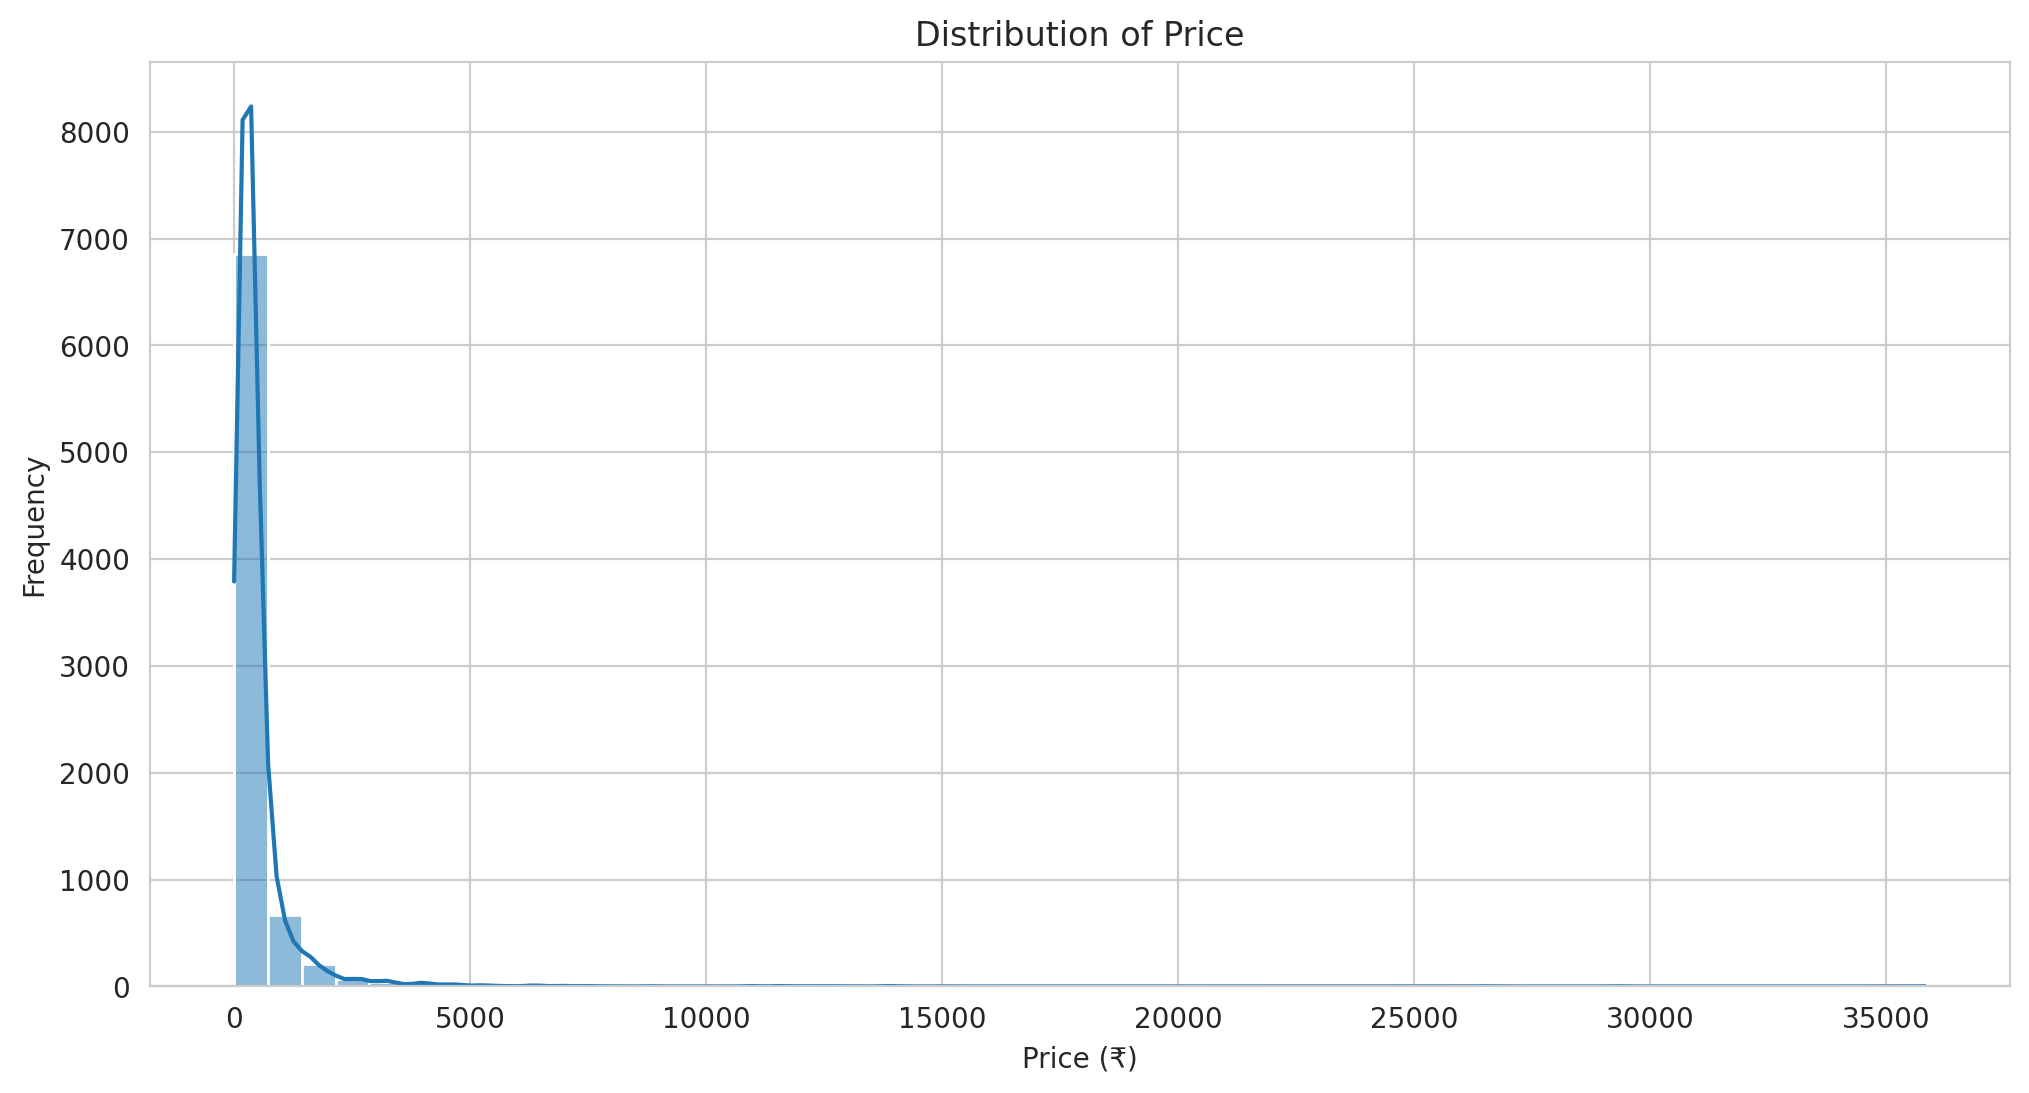

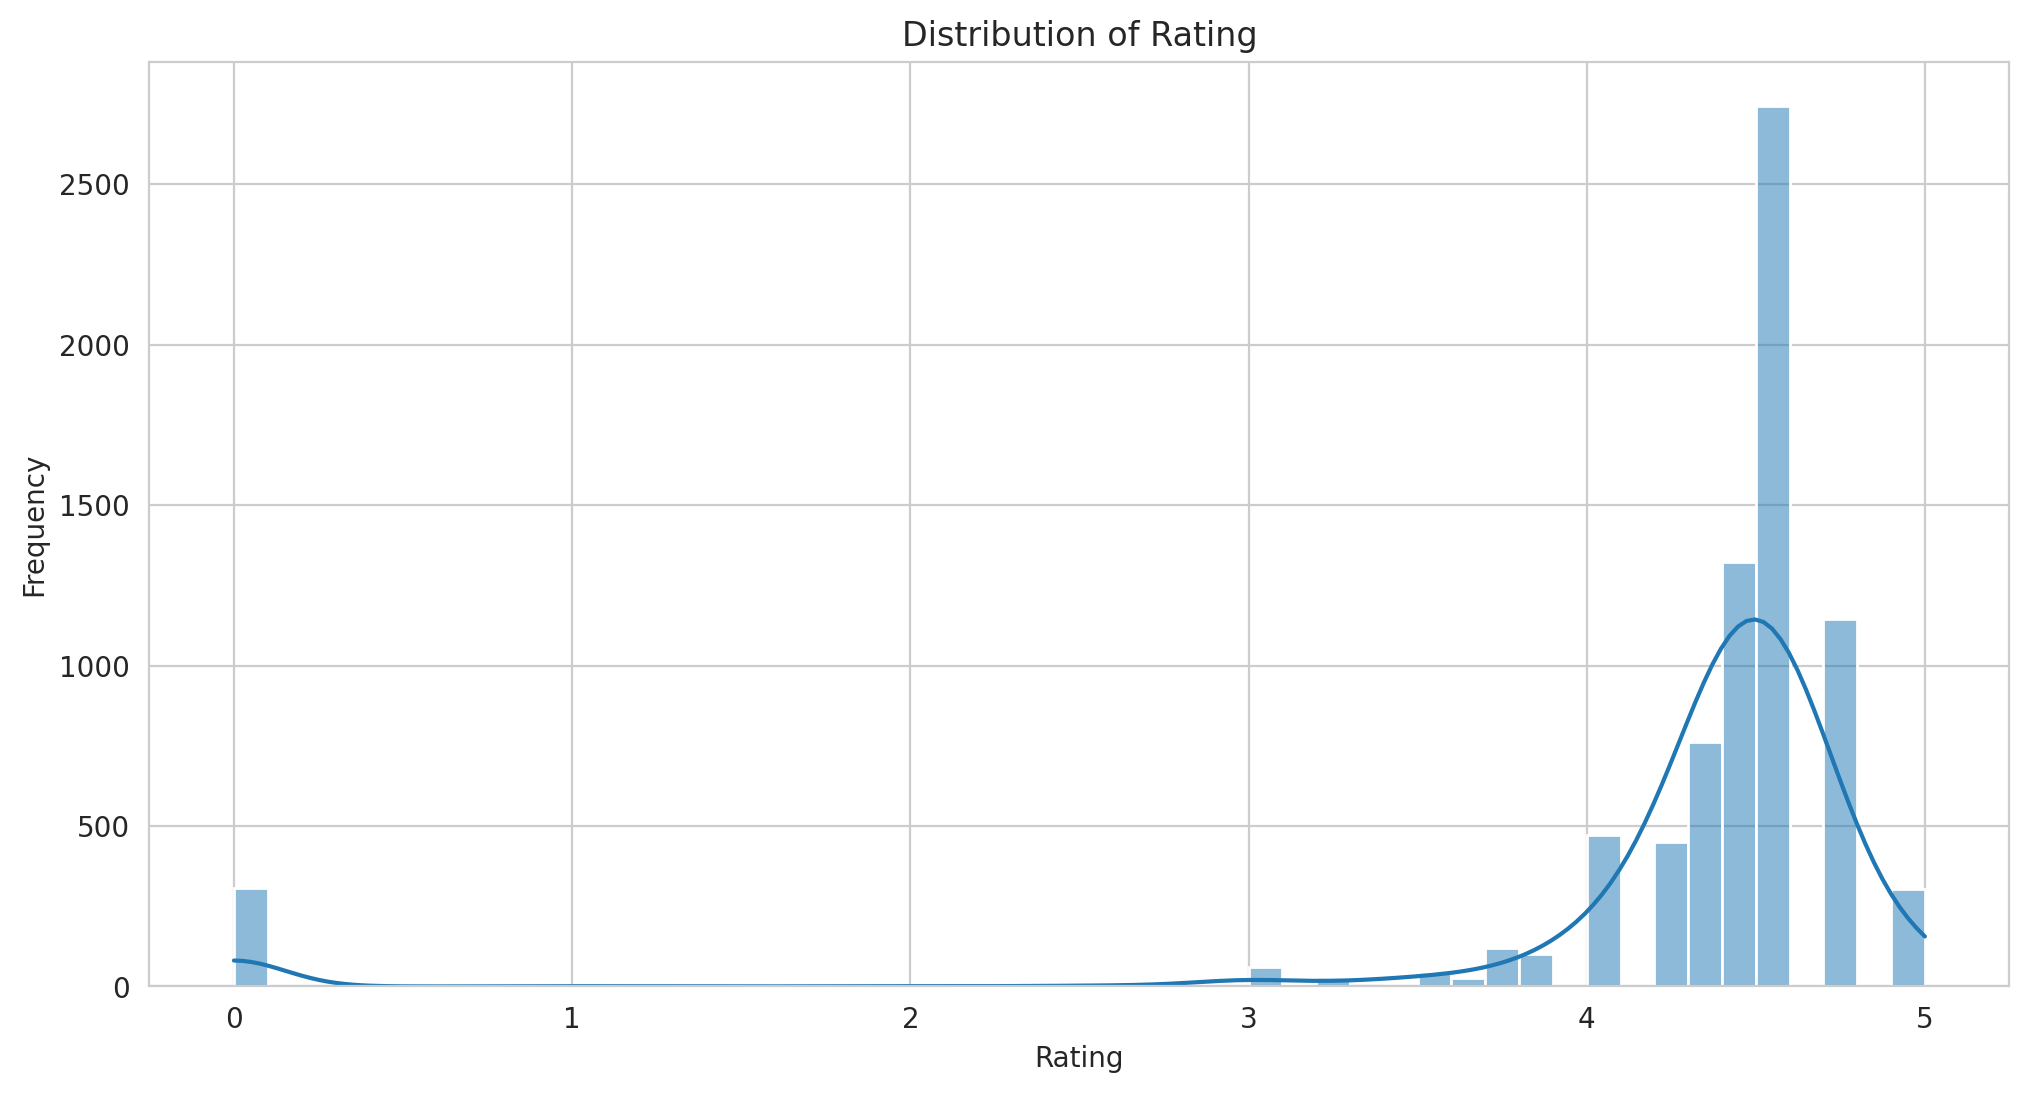

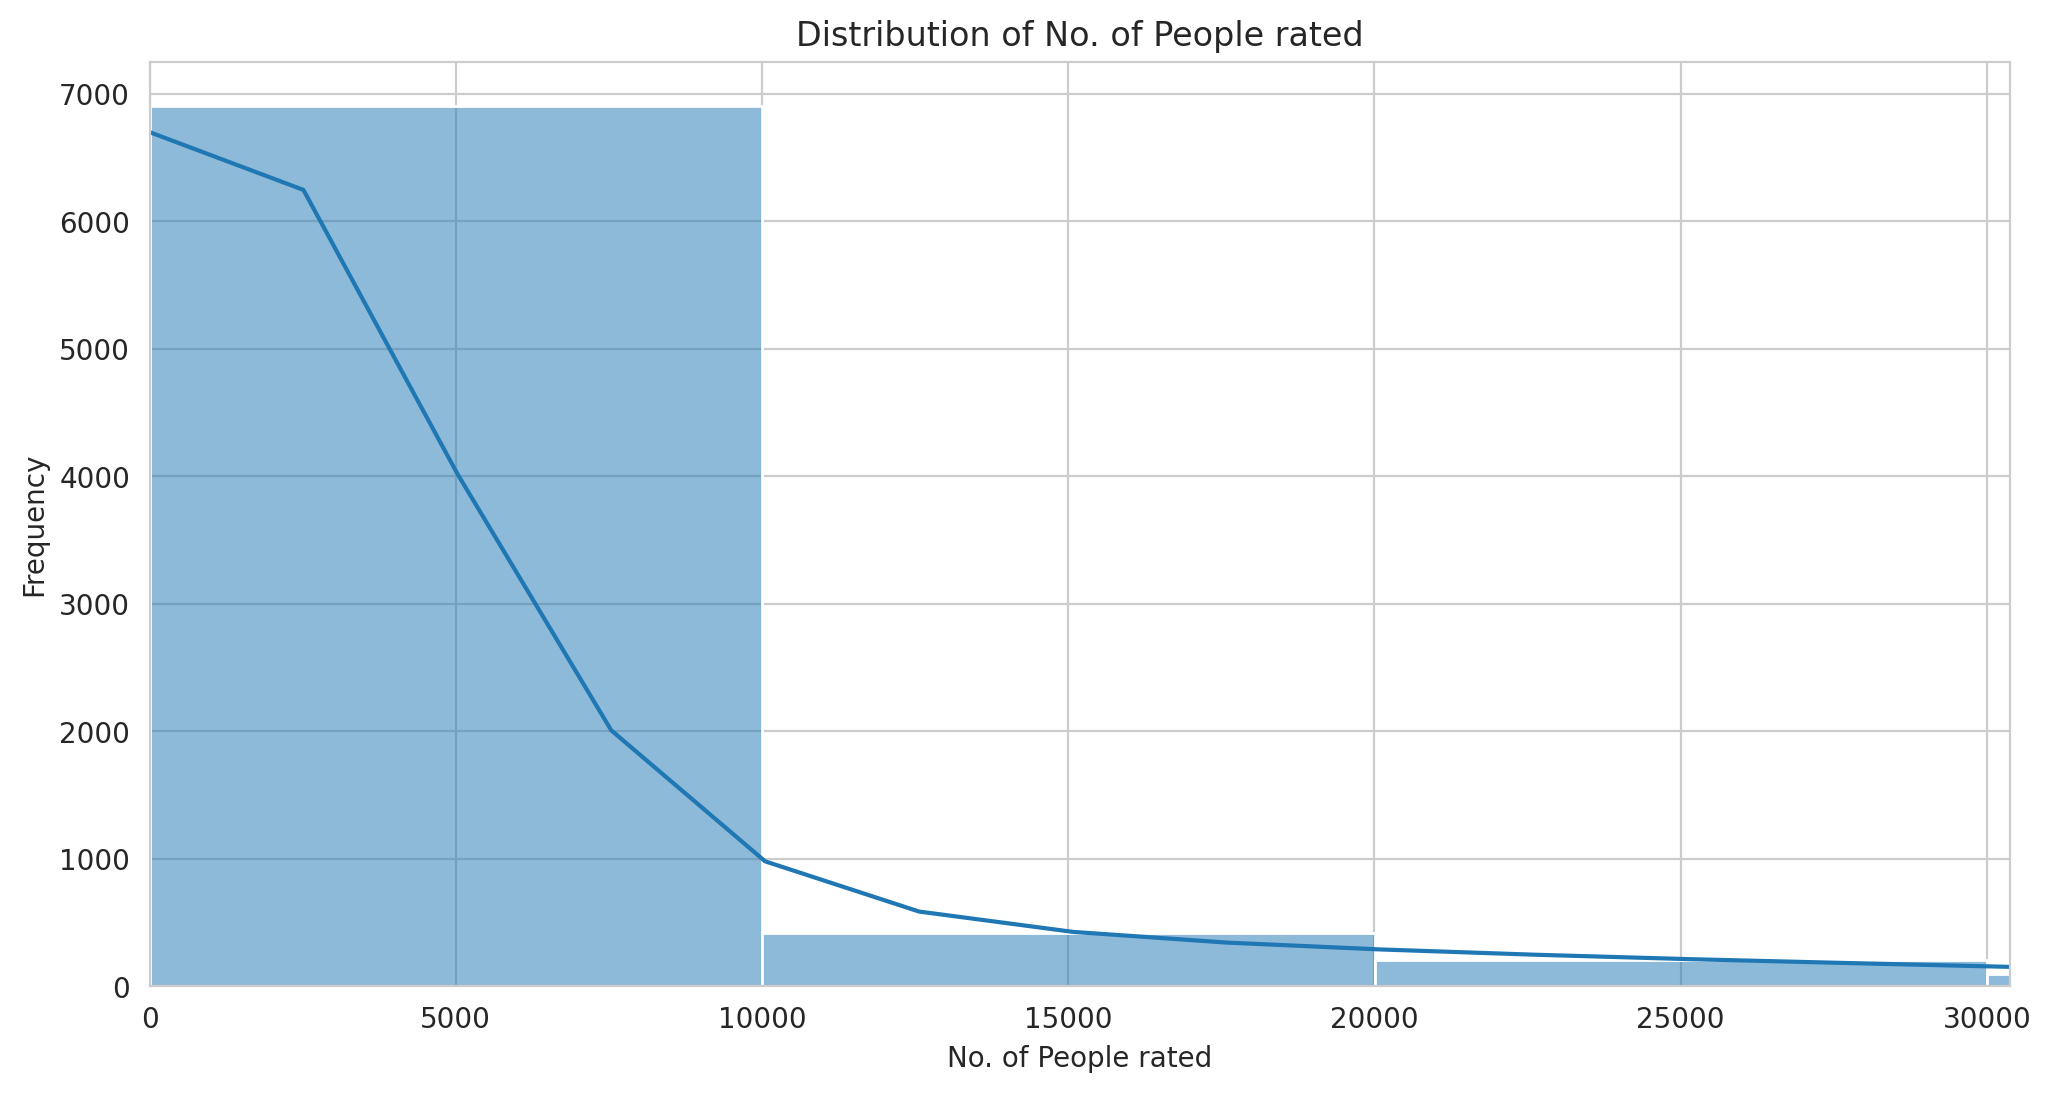

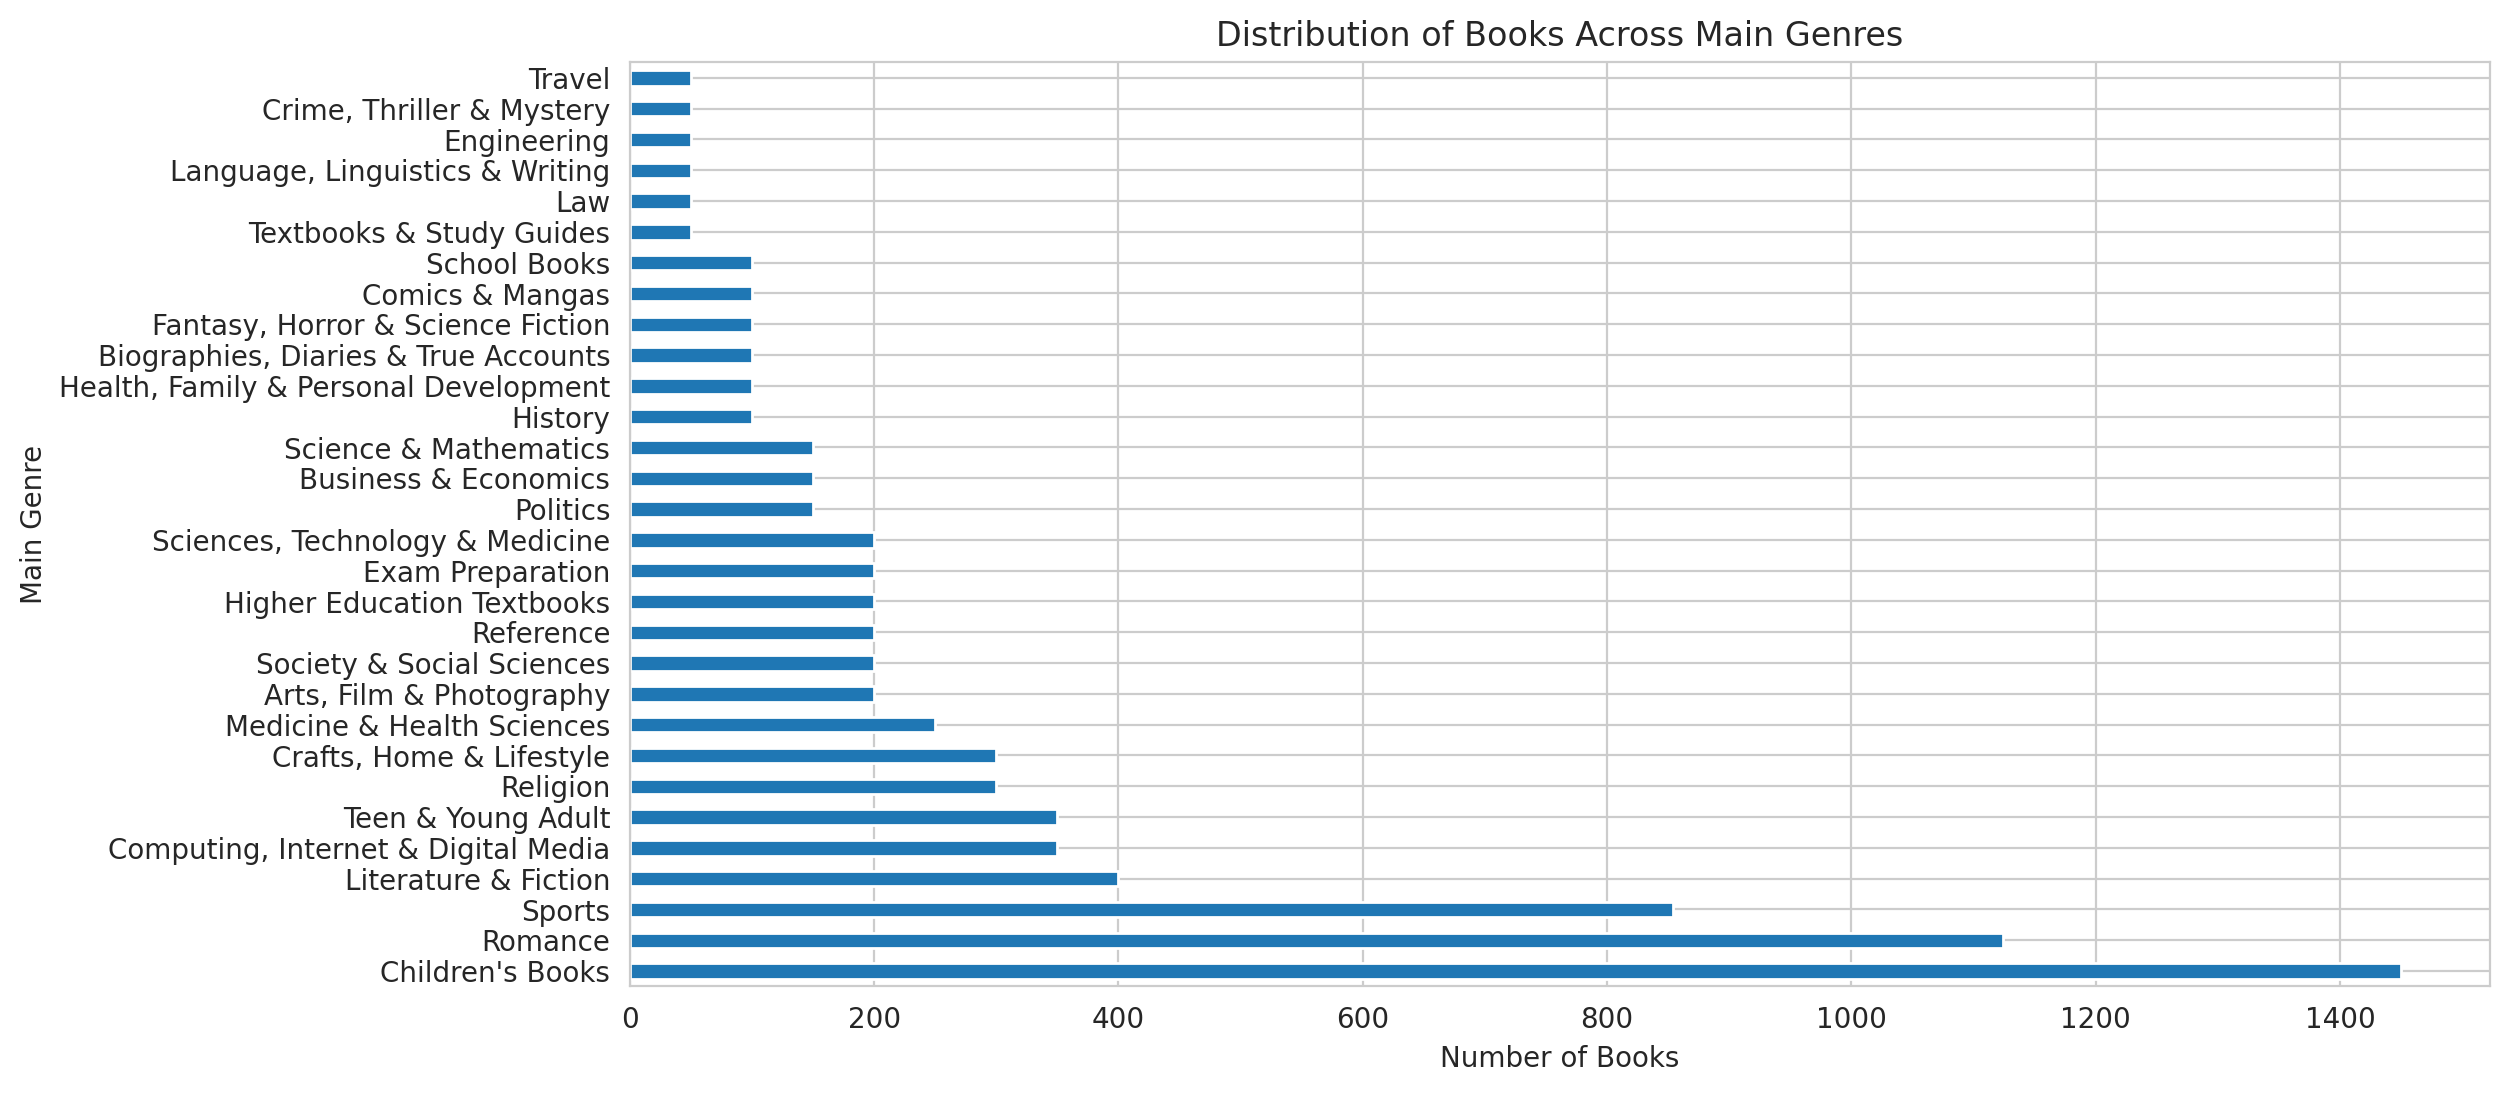

In [6]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Distribution of 'Price'
plt.figure(figsize=(12,6), dpi=200)
sns.histplot(books_df['Price'], bins=50, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price (₹)')
plt.ylabel('Frequency')
plt.show()

# Distribution of 'Rating'
plt.figure(figsize=(12,6), dpi=200)
sns.histplot(books_df['Rating'], bins=50, kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Distribution of 'No. of People rated'
plt.figure(figsize=(12,6), dpi=200)
sns.histplot(books_df['No. of People rated'], bins=50, kde=True)
plt.title('Distribution of No. of People rated')
plt.xlabel('No. of People rated')
plt.ylabel('Frequency')
plt.xlim(0,books_df['No. of People rated'].quantile(0.95)) # Limiting x-axis to 95th percentile for better visualization
plt.show()

# Distribution of books across different Main Genres
plt.figure(figsize=(12,6), dpi=200)
books_df['Main Genre'].value_counts().plot(kind='barh')
plt.title('Distribution of Books Across Main Genres')
plt.xlabel('Number of Books')
plt.ylabel('Main Genre')
plt.show()

In [7]:
# Set a minimum threshold for the number of ratings to be considered for 'Best Rated Authors'
min_ratings_threshold = 1000

# Group by 'Author' and calculate mean rating, mean price, and total number of ratings
author_stats = books_df.groupby('Author').agg({
    'Rating':'mean',
    'Price':'mean',
    'No. of People rated':['sum','mean']
}).reset_index()

# Flatten the multi-levelcolumn names
author_stats.columns = ['Author','Avg Rating','Avg Price','Total Ratings','Avg Ratings per Book']

# Filter authors to ensure they have a signficant number of ratings for reliability
best_rated_authors = author_stats[author_stats['Avg Ratings per Book'] > min_ratings_threshold].sort_values(by='Avg Rating', ascending=False).head(10)

# Identify the most expensive authors
most_expensive_authors = author_stats.sort_values(by='Avg Price', ascending=False).head(10)

# Identify the ost rated authors
most_rated_authors = author_stats.sort_values(by='Total Ratings', ascending=False).head(10)

best_rated_authors, most_expensive_authors,most_rated_authors

(                       Author  Avg Rating  Avg Price  Total Ratings  \
 1644              Joy Alukkas         5.0     464.88         1274.0   
 2175  Michael Dante DiMartino         4.9    2148.00         1615.0   
 513            Bret Contreras         4.9    4119.00         5120.0   
 1174             Frank Thomas         4.9    4079.00         1903.0   
 3379            Trent Shelton         4.9     567.00         1070.0   
 3306             Tatsuya Endo         4.9     492.00         5053.0   
 947        Dr. Aaron Horschig         4.9    4594.00         3475.0   
 727            Cori Doerrfeld         4.9     389.00        12927.0   
 1822         L. M. Montgomery         4.9     442.69         1990.0   
 1908       Little Tiger Press         4.9     226.00        71361.0   
 
       Avg Ratings per Book  
 1644                1274.0  
 2175                1615.0  
 513                 5120.0  
 1174                1903.0  
 3379                1070.0  
 3306                5053.

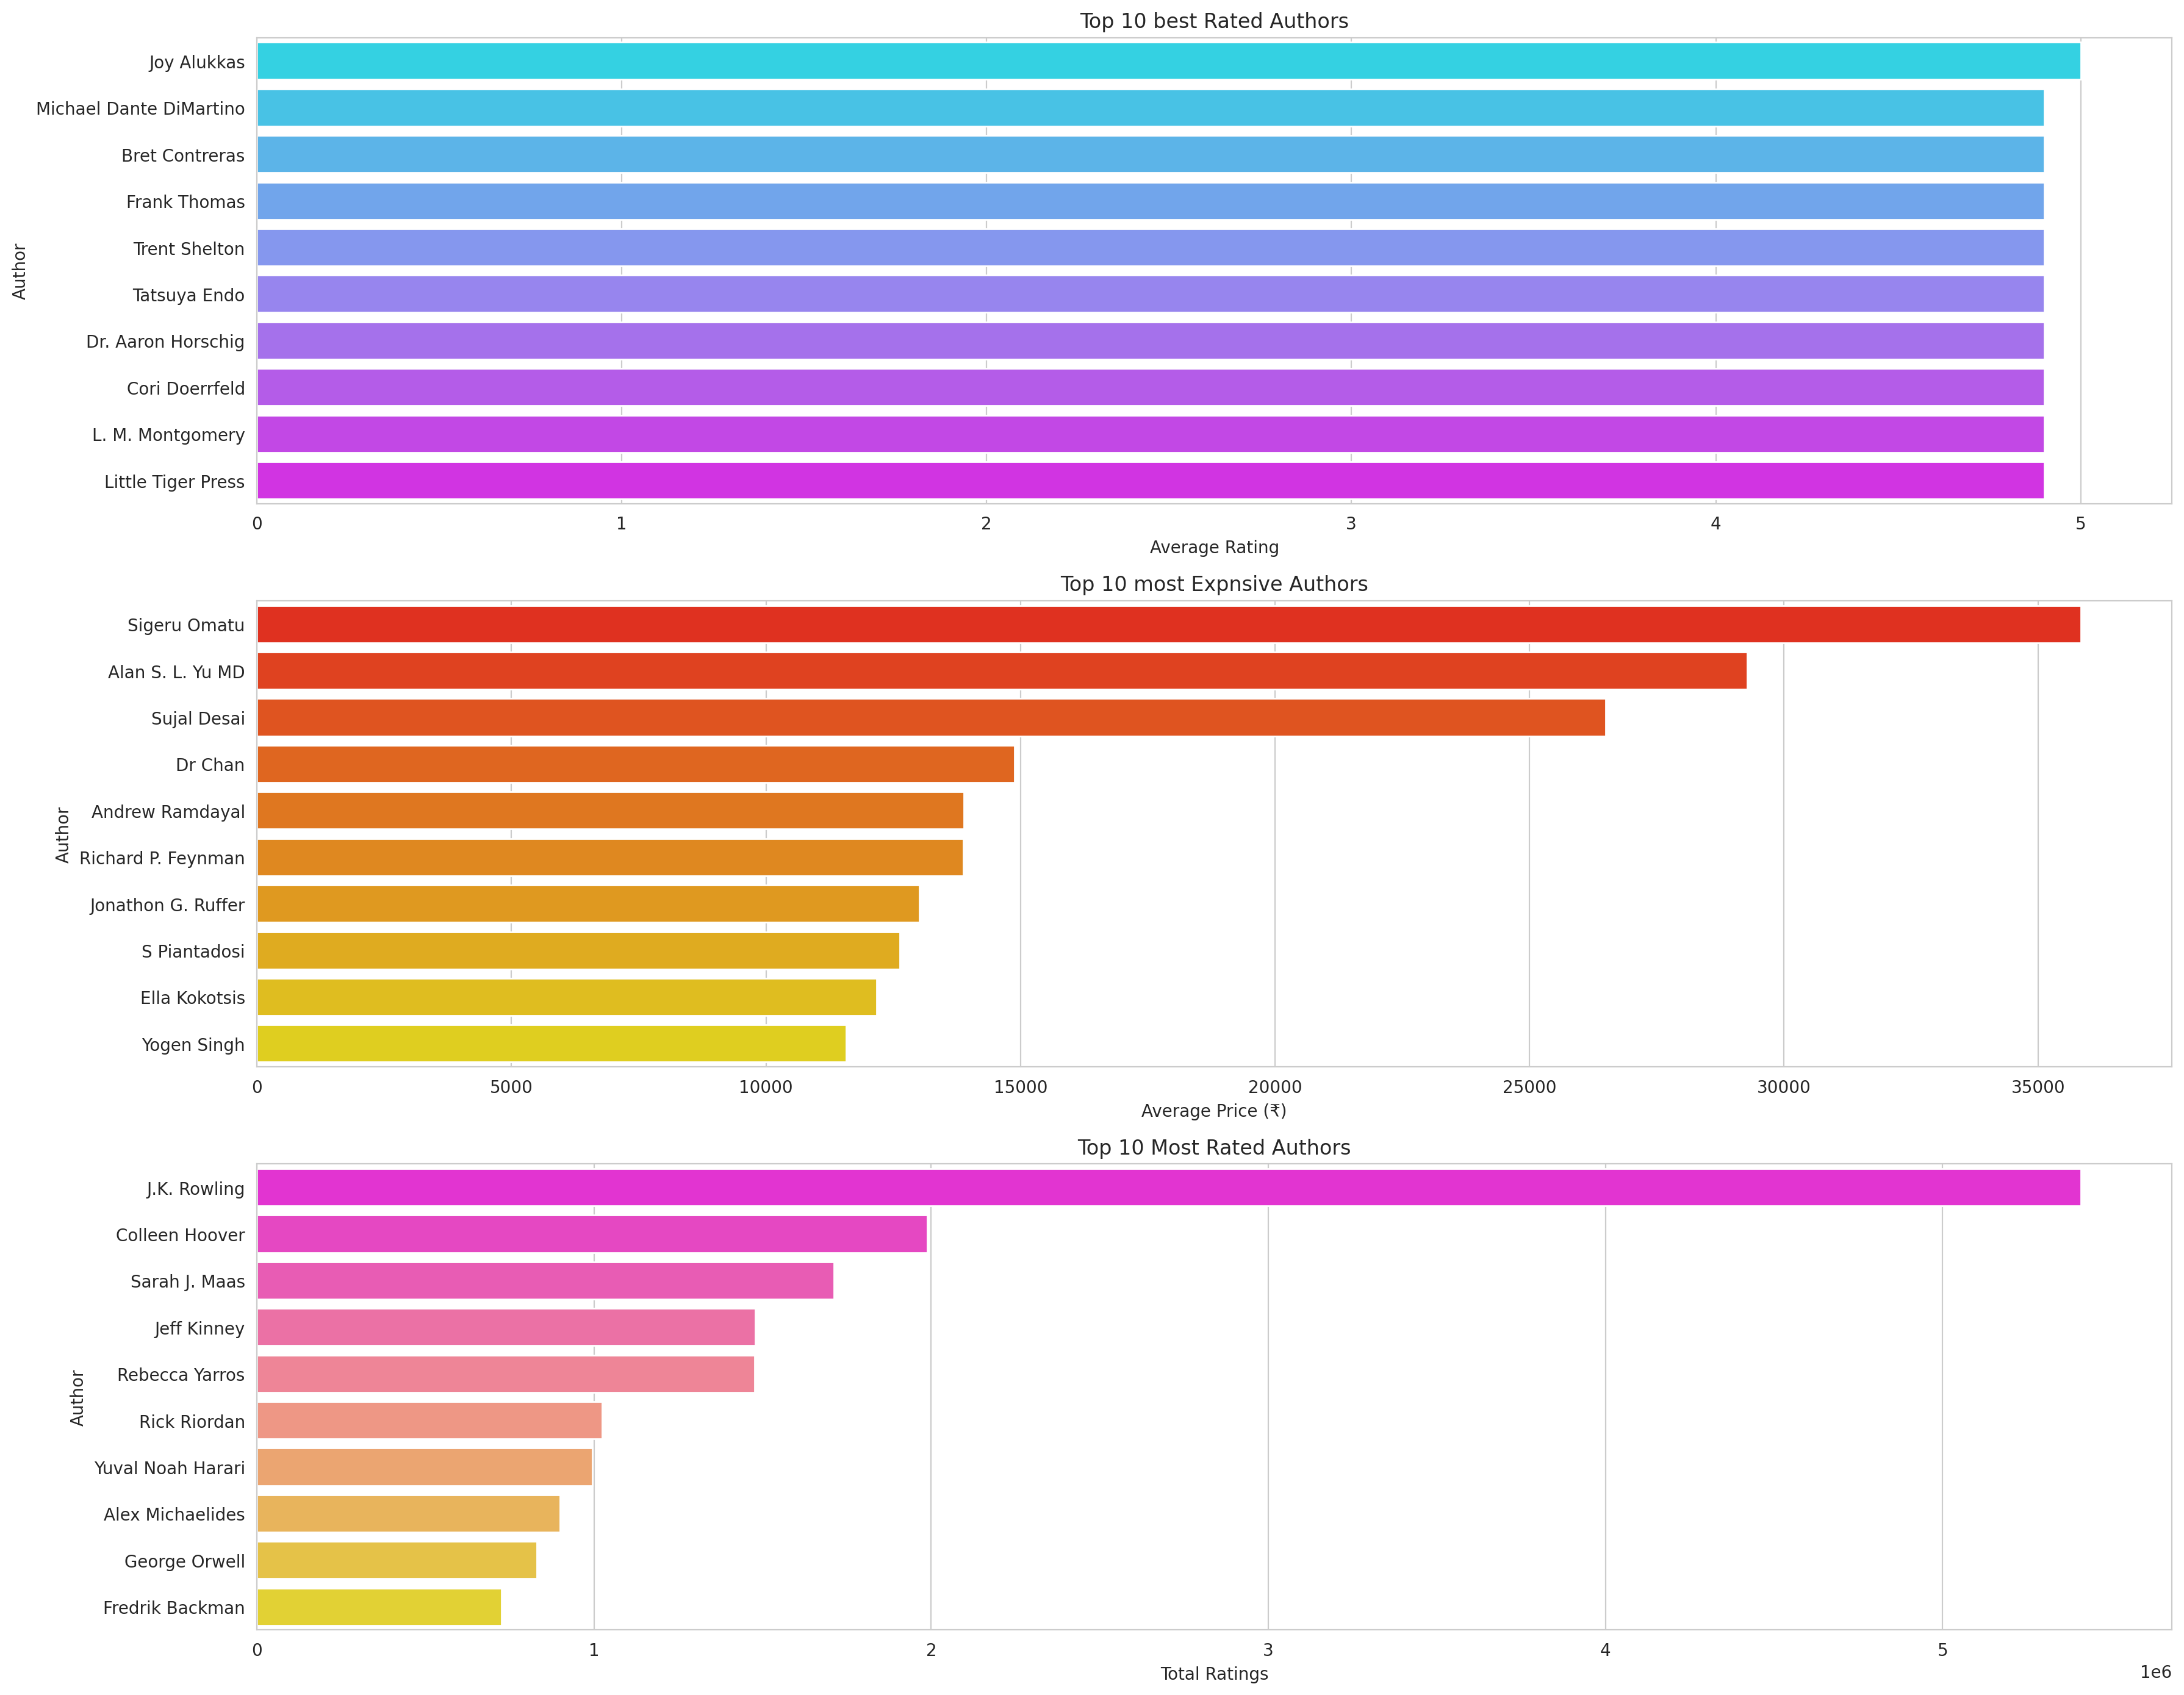

In [8]:
# Visualization setup
plt.figure(figsize=(18,14),dpi=200)

# Best Rated Authors
plt.subplot(3,1,1)
sns.barplot(x='Avg Rating', y='Author', data=best_rated_authors, palette='cool')
plt.title('Top 10 best Rated Authors')
plt.xlabel('Average Rating')
plt.ylabel('Author')

# Most Expensive Authors
plt.subplot(3,1,2)
sns.barplot(x='Avg Price', y='Author', data=most_expensive_authors,palette='autumn')
plt.title('Top 10 most Expnsive Authors')
plt.xlabel('Average Price (₹)')
plt.ylabel('Author')

# Most Rated Authors
plt.subplot(3,1,3)
sns.barplot(x='Total Ratings',y='Author',data=most_rated_authors,palette='spring')
plt.title('Top 10 Most Rated Authors')
plt.xlabel('Total Ratings')
plt.ylabel('Author')

plt.tight_layout()
plt.show()

In [9]:
# Step 1: Filter books with an average rating of 4.5 or higher
highly_rated_books = books_df[books_df['Rating']>=4.5]

# Determine a threshold for 'fewer than a certain number of reviews'
# Let's consider books in the lower 25% in the number of ratings amongthe highlyrated ones as less discovered
ratings_threshold = highly_rated_books['No. of People rated'].quantile(0.25)

# Step 2: Identify books with fewer than the threshold number of views
hidden_gems = highly_rated_books[highly_rated_books['No. of People rated']<=ratings_threshold]

# Sort by rating and then by price o find high-quality, less reviewed, and potentially good value books
hidden_gems_sorted = hidden_gems.sort_values(by=['Rating','Price'],ascending=[False,True])

# Display the top 10 hidden gems
hidden_gems_sorted.head(10)

Title  \
4947  Struggle To Spark: 5 Effective Ways To Save Yo...   
2941                               IC-38 Life Insurance   
1332  Super Froggy Begins – A Fun-Filled Early Reade...   
3046                    Metamorphosis (Pocket Classics)   
6972      Mountain Biking Mastery: A Beginner’s Gateway   
2627  SPEAK WITH YOUR EYES: Understanding Facial Exp...   
5011  SELF MANAGEMENT: SKILL REQUIRED FOR SELF-MANAG...   
2920  Arihant NTA CUET UG 15 Mock Test For Section 2...   
2937  Arihant NTA CUET UG 15 Mock Test For Section 2...   
7661  Sudoku Puzzles - Book 4 - Brain Activity Book ...   

                                 Author                         Main Genre  \
4947                     ANAMIKA MISHRA                            Romance   
2941              Mohinder Singh Kamboj                   Exam Preparation   
1332                     Elisa Anderson                   Children's Books   
3046                        Franz Kafka  Fantasy, Horror & Science Fiction   
6972                      Aaron Webster                             Sports   
2627                  Reshmi Nair Ghosh           Crafts, Home & Lifestyle   
5011                       RAMKISHORE M                            Romance   
2920  Abhishikha Kaushik Swati chauhan                    Exam Preparation   
2937                       Punya Pratap                   Exam Preparation   
7661                        Maple Press                 Teen & Young Adult   

                              Sub Genre            Type  Price  Rating  \
4947                        Adaptations  Kindle Edition   49.0     5.0   
2941   Professional Certification Exams  Kindle Edition   60.0     5.0   
1332                             Humour  Kindle Edition   69.0     5.0   
3046                             Horror       Paperback   80.0     5.0   
6972                            Cycling  Kindle Edition   83.0     5.0   
2627  Lifestyle & Personal Style Guides  Kindle Edition   85.0     5.0   
5011                              Amish  Kindle Edition   89.0     5.0   
2920   Professional Certification Exams       Paperback   90.0     5.0   
2937   Professional Certification Exams       Paperback   90.0     5.0   
7661                    Hobbies & Games       Paperback   98.0     5.0   

      No. of People rated                                               URLs  
4947                  7.0  https://www.amazon.in/Struggle-Spark-Effective...  
2941                  1.0  https://www.amazon.in/IC-38-Insurance-Mohinder...  
1332                  5.0  https://www.amazon.in/Super-Froggy-Begins-Kind...  
3046                  1.0  https://www.amazon.in/Metamorphosis-Pocket-Cla...  
6972                  3.0  https://www.amazon.in/Mountain-Biking-Mastery-...  
2627                 23.0  https://www.amazon.in/SPEAK-YOUR-EYES-Understa...  
5011                 10.0  https://www.amazon.in/SELF-MANAGEMENT-SELF-MAN...  
2920                  1.0  https://www.amazon.in/Arihant-Section-Science-...  
2937                  1.0  https://www.amazon.in/Arihant-Section-Science-...  
7661                  3.0  https://www.amazon.in/Sudoku-Puzzles-Brain-Act...

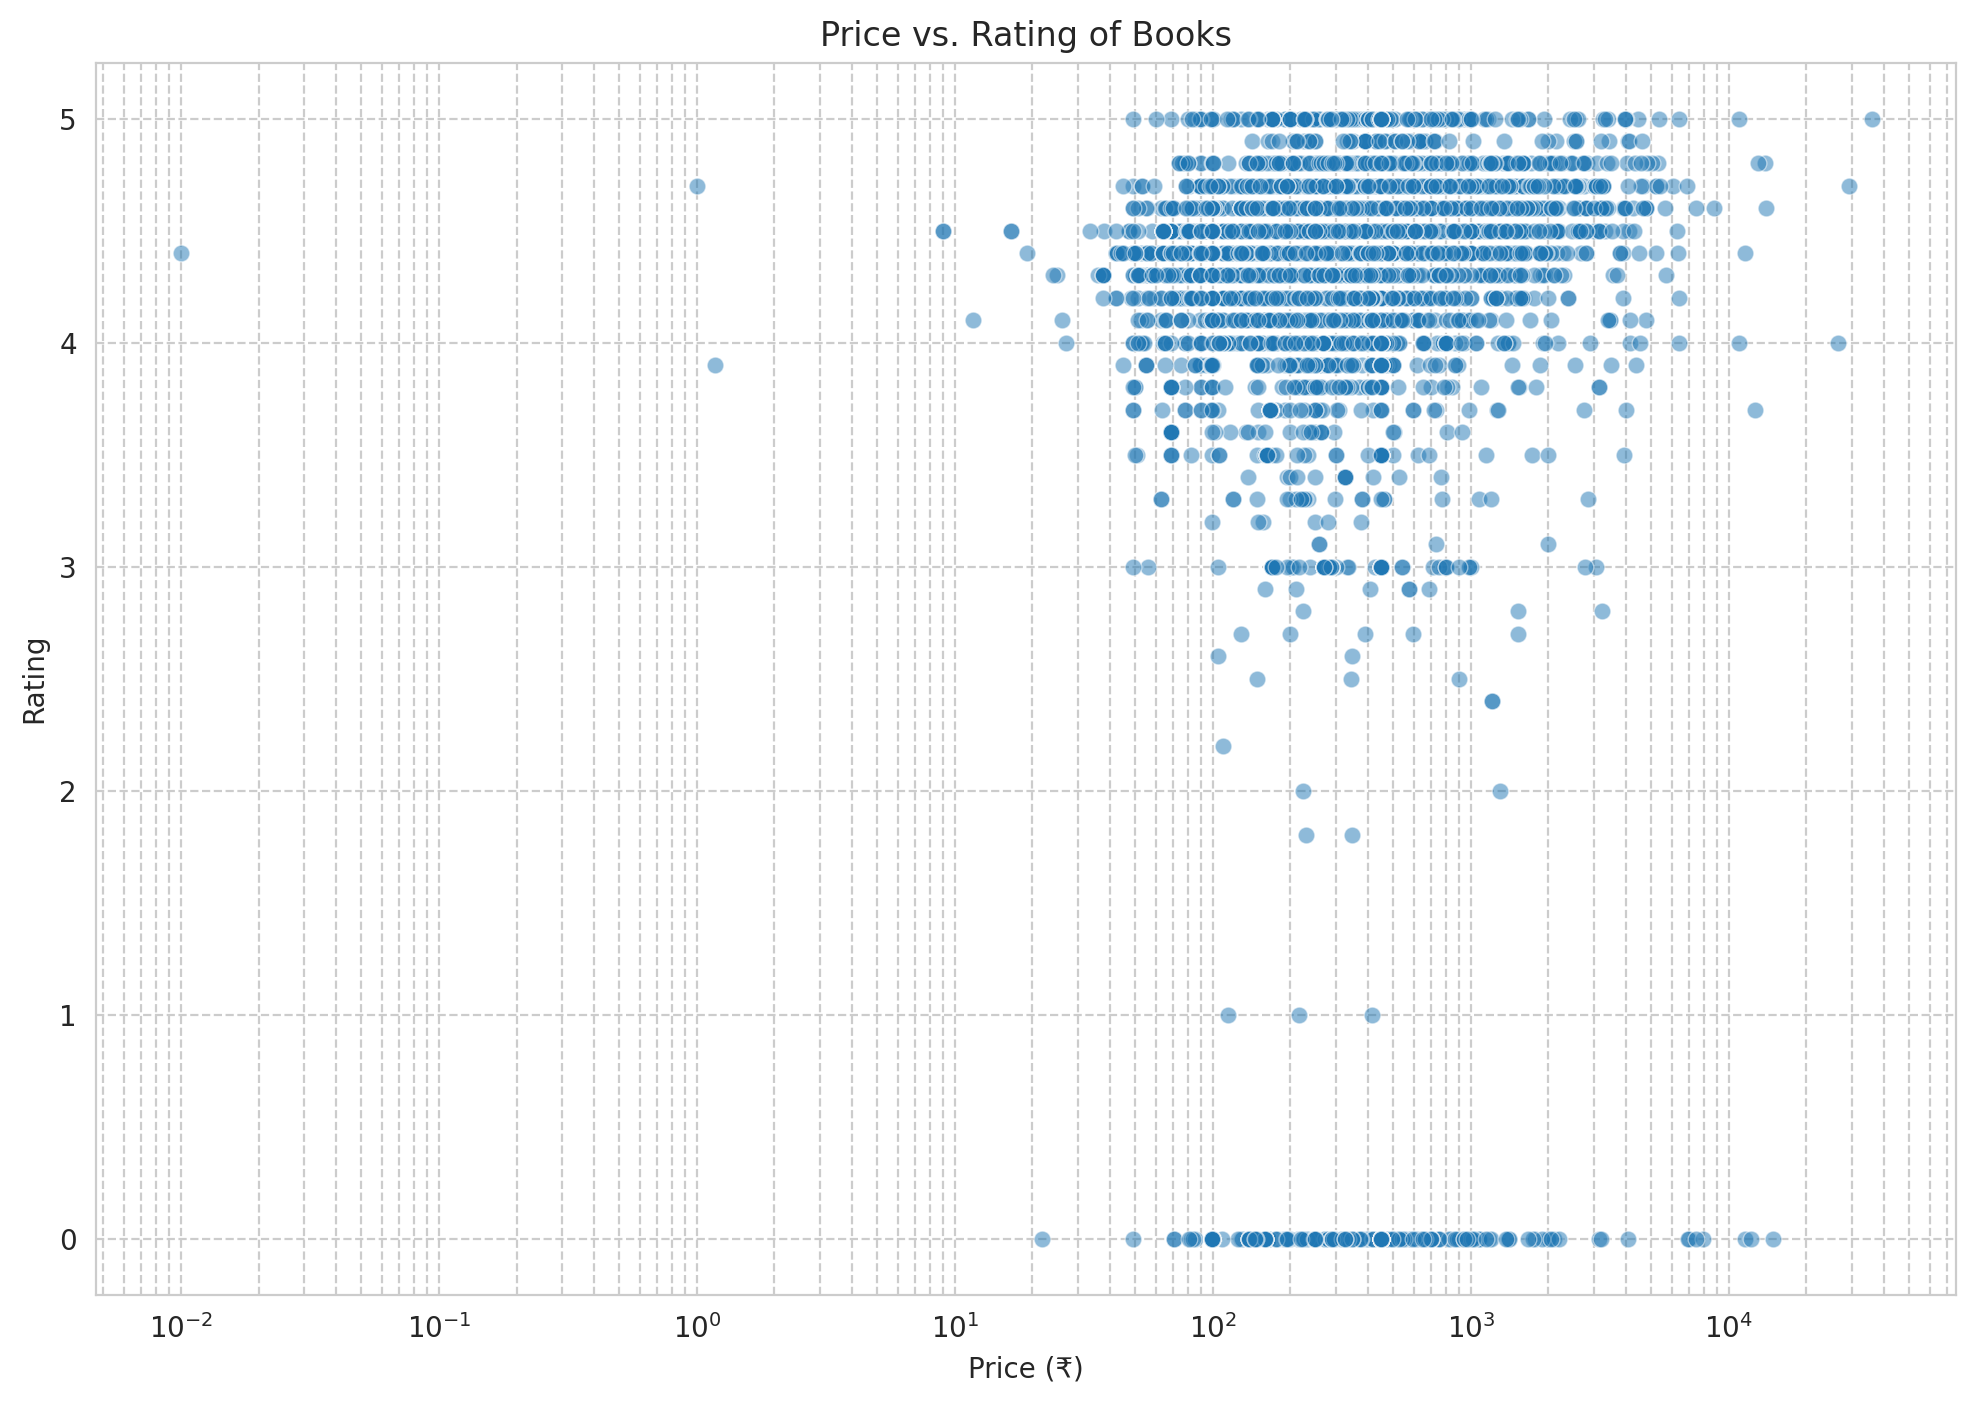

In [10]:
# Price vs. Rating Scatter Plot
plt.figure(figsize=(12,8),dpi=200)
sns.scatterplot(x='Price',y='Rating',data=books_df,alpha=0.5)
plt.title('Price vs. Rating of Books')
plt.xlabel('Price (₹)')
plt.ylabel('Rating')
plt.xscale('log') # Using a logarithmic scale better visualization of a wide range of prices
plt.grid(True,which="both",ls="--")
plt.show()

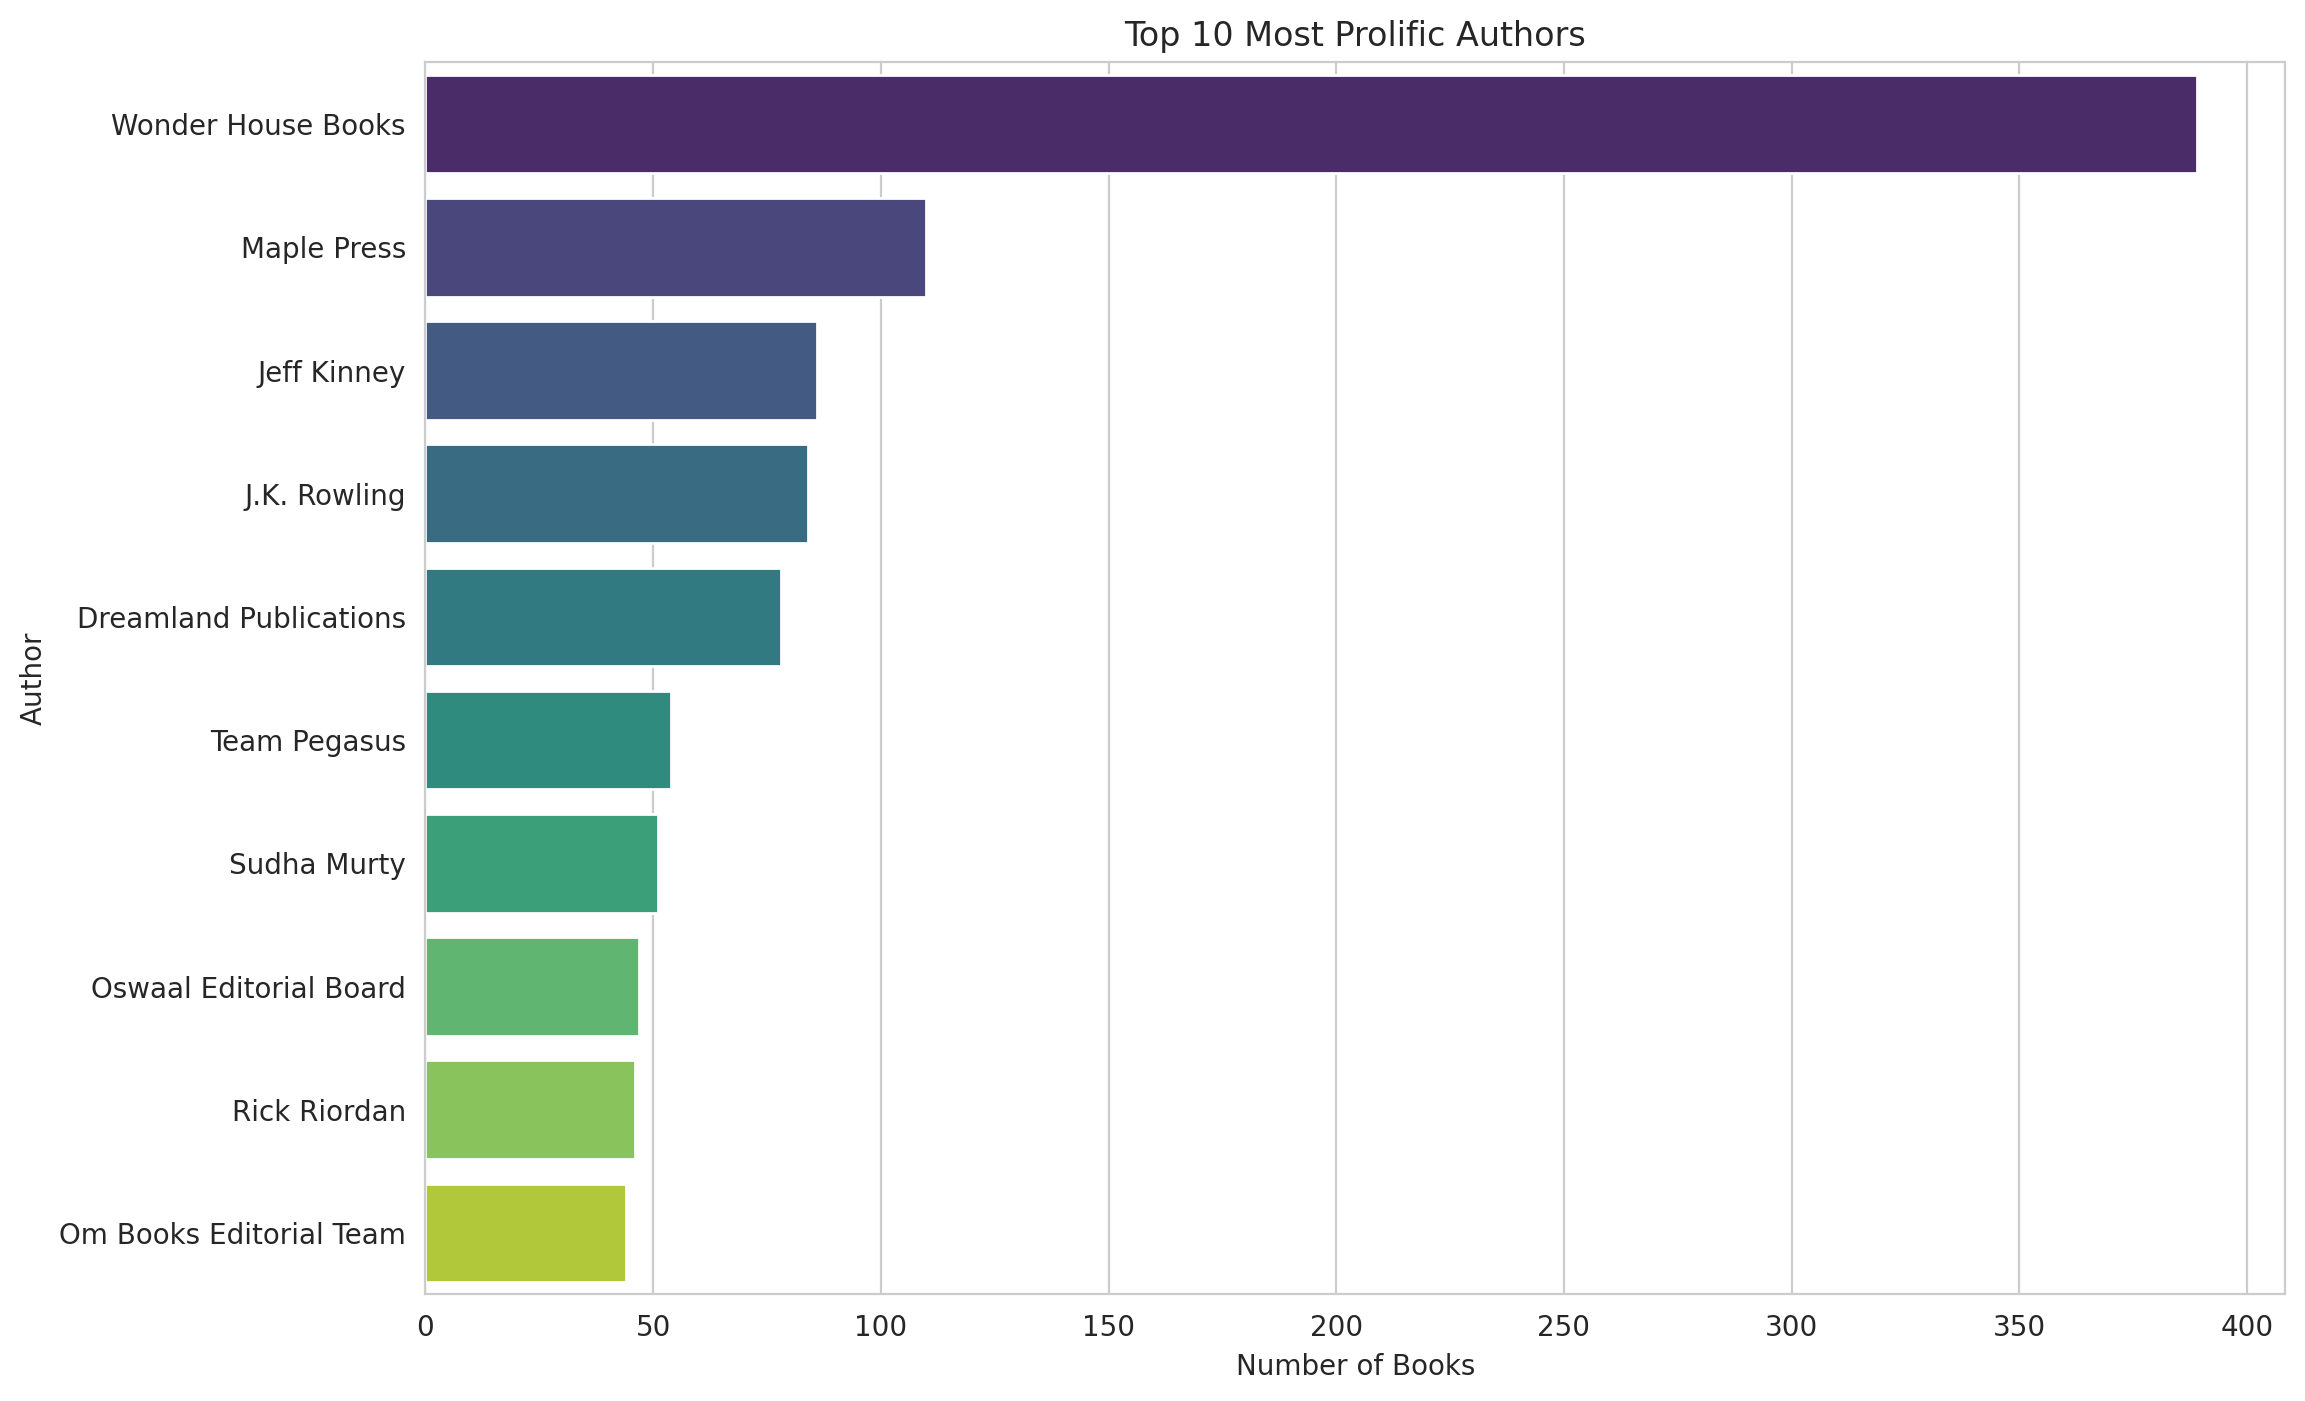

In [11]:
# Count the number of books per author
books_per_author = books_df['Author'].value_counts().reset_index()
books_per_author.columns = ['Author', 'Number of Books']

# Take the top 10 most prolific authors for visualization
top_authors = books_per_author.head(10)

# Visualization
plt.figure(figsize=(12, 8), dpi=200)
sns.barplot(x='Number of Books', y='Author', data=top_authors, palette='viridis')
plt.title('Top 10 Most Prolific Authors')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()

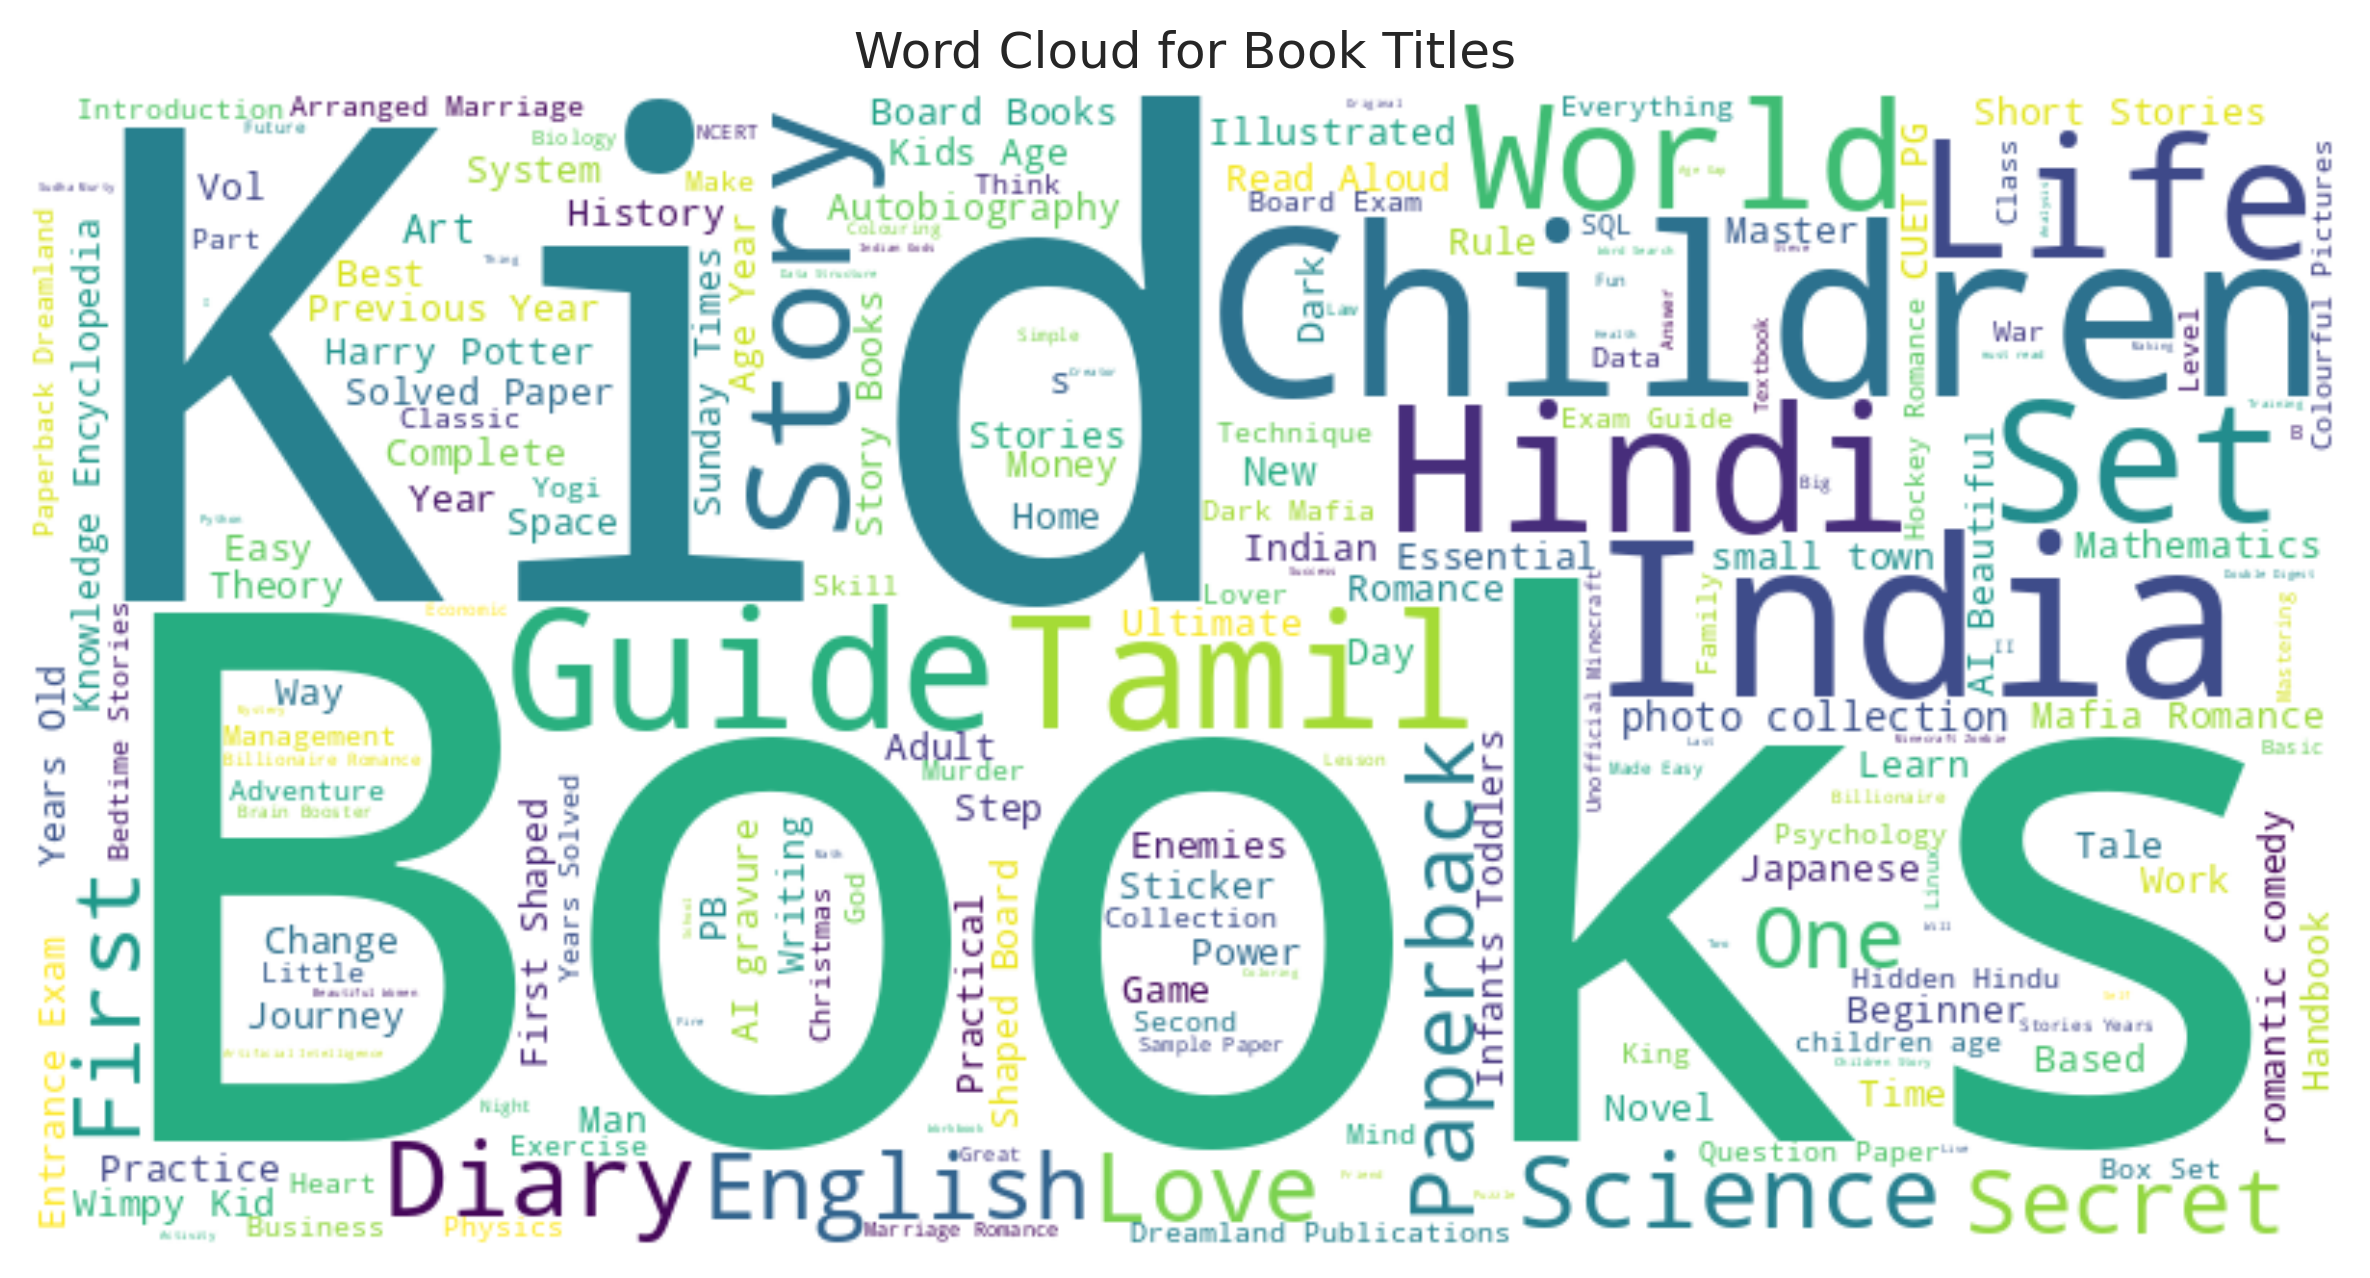

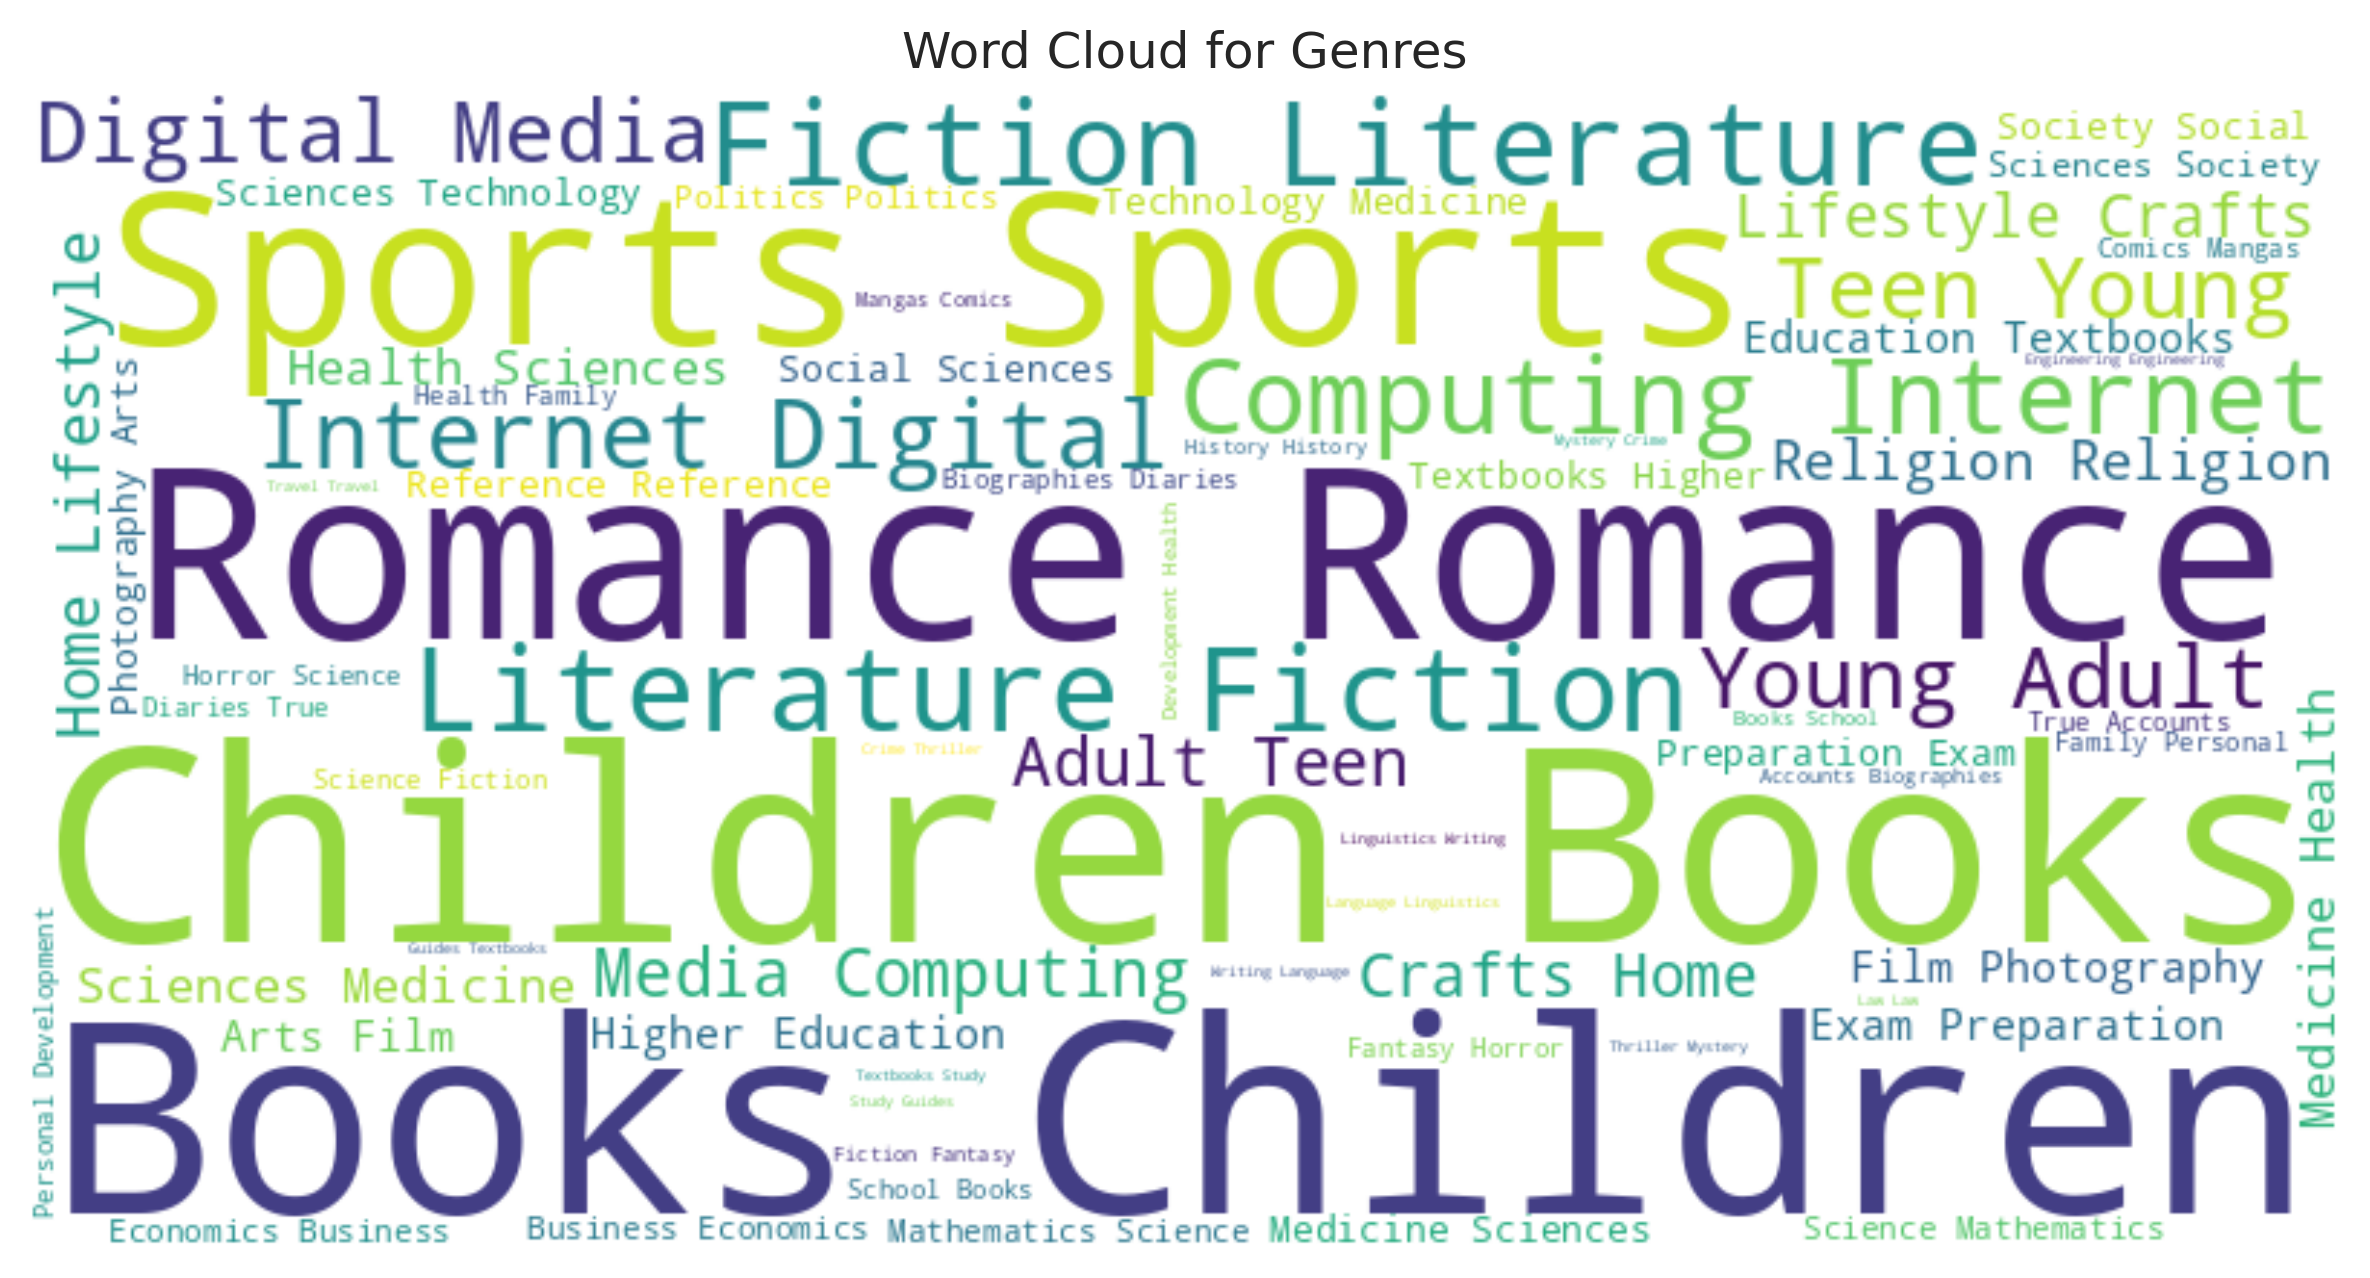

In [12]:
# Combine all book titles into a single string
all_titles = ' '.join(books_df['Title'])

# Combine all genres into a single string
all_genres = ' '.join(books_df['Main Genre'])

# Define additional stopwords to exclude common words that may not add value to the visualization
additional_stopwords = {'Edition', 'Volume', 'Series', 'Book'}

# Update the stopwords set with the additional stopwords
stopwords = set(STOPWORDS).union(additional_stopwords)

# Generate a word cloud for book titles
wordcloud_titles = WordCloud(stopwords=stopwords, background_color='white', width=800, height=400).generate(all_titles)
# Generate a word cloud for genres
wordcloud_genres = WordCloud(stopwords=stopwords, background_color='white', width=800, height=400).generate(all_genres)

# Plotting the word cloud for book titles
plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(wordcloud_titles, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Book Titles')
plt.show()

# Plotting the word cloud for genres
plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(wordcloud_genres, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Genres')
plt.show()

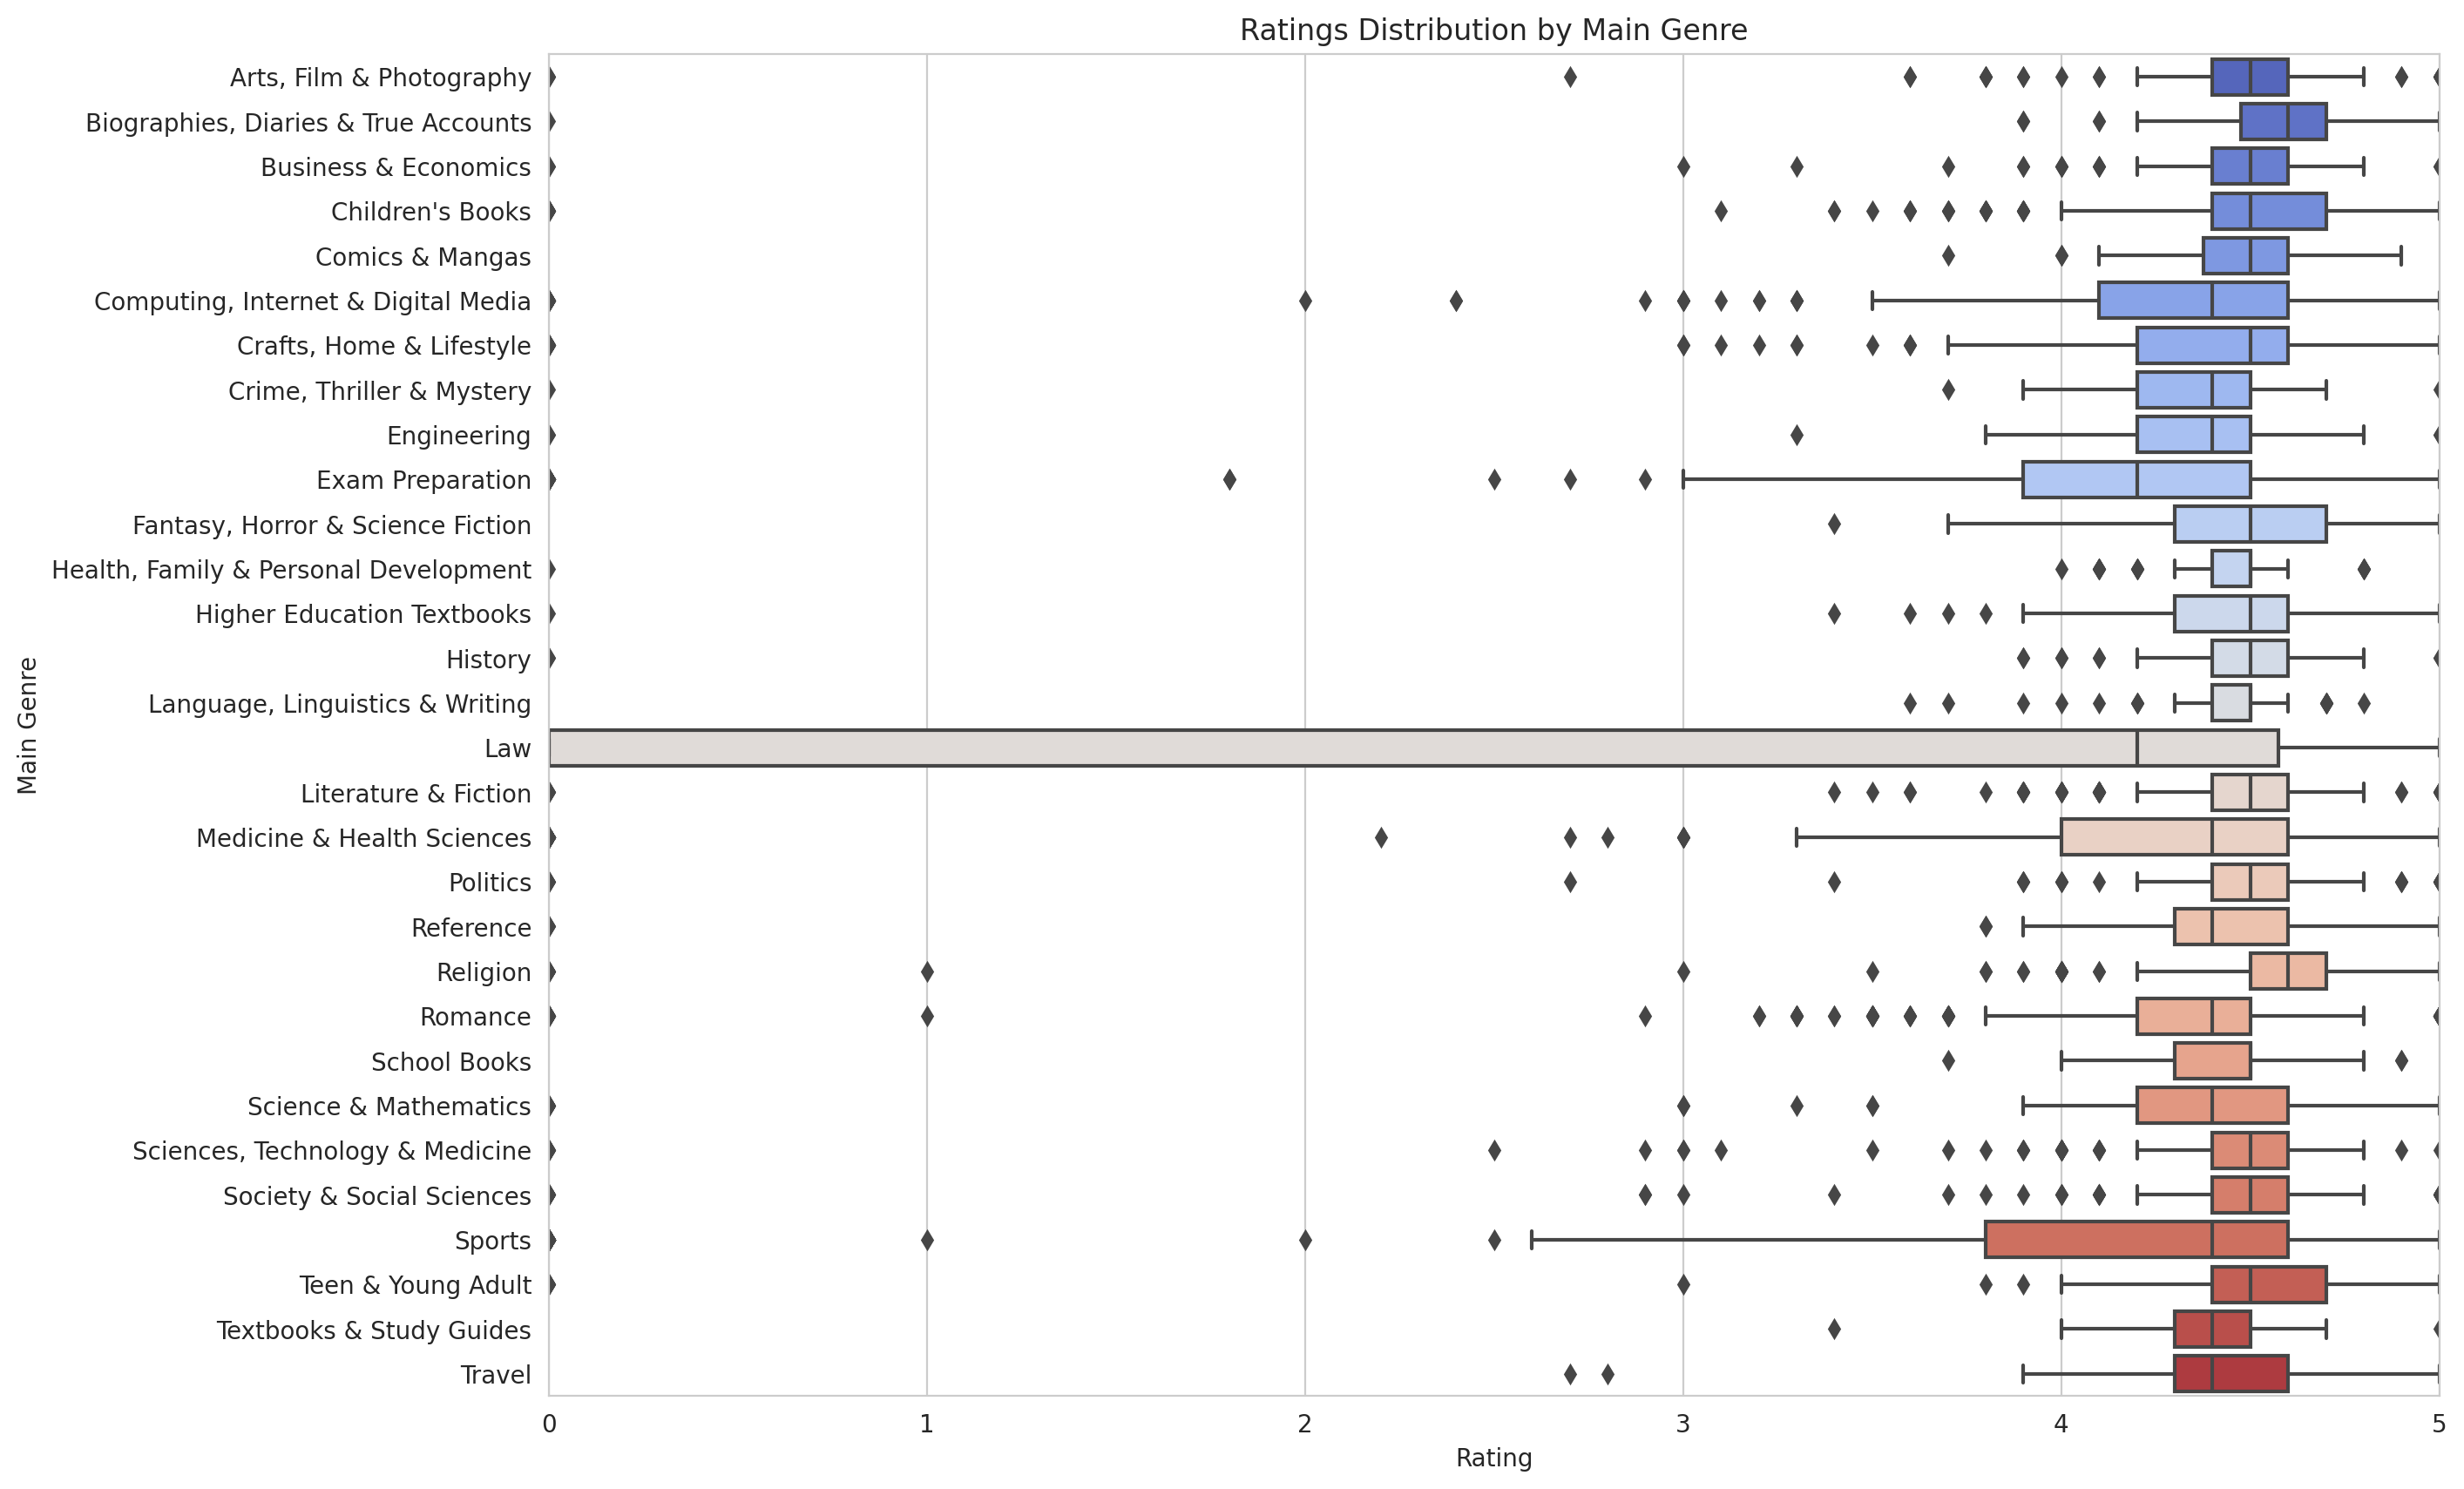

In [13]:
plt.figure(figsize=(14, 10), dpi=200)
sns.boxplot(y='Main Genre', x='Rating', data=books_df, palette="coolwarm")
plt.title('Ratings Distribution by Main Genre')
plt.xlabel('Rating')
plt.ylabel('Main Genre')
plt.xlim(0, 5)  # Ratings are on a scale from 0 to 5
plt.show()

In [14]:
# Step 1: Filter books with a significant number of ratings
# Using the 50th percentile of 'No. of People rated' as a threshold for significant number of ratings
significant_ratings_threshold = books_df['No. of People rated'].quantile(0.50)
filtered_books = books_df[books_df['No. of People rated'] >= significant_ratings_threshold]

# Step 2: Identify the top-rated book within each main genre
top_books_per_genre = filtered_books.loc[filtered_books.groupby('Main Genre')['Rating'].idxmax()]

# Selecting relevant columns for display
top_books_display = top_books_per_genre[['Title', 'Author', 'Main Genre', 'Rating', 'No. of People rated']]

# Sort by genre for better readability
top_books_display_sorted = top_books_display.sort_values(by='Main Genre')

top_books_display_sorted

Title  \
31    Avatar: The Last Airbender The Art of the Anim...   
274                             India's Most Fearless 3   
302   Breakout Trading Made Easy: Maximize Your Prof...   
463                                 The Rabbit Listened   
1987                                Spy X Family: Vol.4   
2242      UNIX and Linux System Administration Handbook   
2443  Diary of Steve the Noob 12 (An Unofficial Mine...   
2680                                       SIX OF CROWS   
2706  Open Circuits: The Inner Beauty of Electronic ...   
2801  PW Physics Med Easy Notes | Notes, Formulas, M...   
3016                            JUJUTSU KAISEN, VOL. 20   
3063  Breakout Trading Made Easy: Maximize Your Prof...   
3193  Spreading Joy: How Joyalukkas Became the World...   
3370                   Discourses and Selected Writings   
3472  PUBLICATION MANUAL OF THE AMERICAN PSYCHOLOGIC...   
3545  IIBF’s IT Security – Covering all Essentials o...   
3708           Harry Potter and the Prisoner of Azkaban   
4017           Textbook of Neonatal Resuscitation (Nrp)   
4205            Savarkar: Echoes from a Forgotten Past,   
4401                    Shrimad Bhagwat Geeta Yatharoop   
4653  S ISLAMIC STORE original product - The Holy Qu...   
5278  A Court of Thorns and Roses Paperback Box Set ...   
6024  Oxford Student Atlas for India, Fourth Edition...   
6075  Dr. Cuterus : Everything Nobody Tells You Abou...   
6242  What We See in the Stars: An Illustrated Tour ...   
6484                                Women, Race & Class   
6689                                      The Glute Lab   
7495  Straight Up: Honest, Unfiltered, As-Real-As-I-...   
7845  SSB Interview: The Complete Guide, Second Edition   
7883  The Comfort Crisis: Embrace Discomfort T: Embr...   

                                     Author  \
31                  Michael Dante DiMartino   
274                             Rahul Singh   
302                            Sunil Gurjar   
463                          Cori Doerrfeld   
1987                           Tatsuya Endo   
2242                             Evi Nemeth   
2443                         Steve the Noob   
2680                          Leigh Bardugo   
2706                        Eric Schlaepfer   
2801               Dr. Manish Raj (MR. Sir)   
3016                           Gege Akutami   
3063                           Sunil Gurjar   
3193                            Joy Alukkas   
3370                              Epictetus   
3472     American Psychological Association   
3545  Indian Institute of Banking & Finance   
3708                           J.K. Rowling   
4017                          Gary M Weiner   
4205                         Vikram Sampath   
4401   A.C. Bhaktivendanta Swami Prabhupada   
4653                                  Allah   
5278                          Sarah J. Maas   
6024                Oxford University Press   
6075                     Dr Tanaya Narendra   
6242                           Kelsey Oseid   
6484                        Angela Y. Davis   
6689                         Bret Contreras   
7495                          Trent Shelton   
7845                     Dr. N.K. Natarajan   
7883                         Michael Easter   

                                 Main Genre  Rating  No. of People rated  
31                 Arts, Film & Photography     4.9               1615.0  
274    Biographies, Diaries & True Accounts     4.8                530.0  
302                    Business & Economics     4.8               1408.0  
463                        Children's Books     4.9               4309.0  
1987                        Comics & Mangas     4.9               5053.0  
2242    Computing, Internet & Digital Media     4.8                651.0  
2443               Crafts, Home & Lifestyle     4.9               2093.0  
2680              Crime, Thriller & Mystery     4.7              35302.0  
2706                            Engineering     4.8                704.0  
2801        

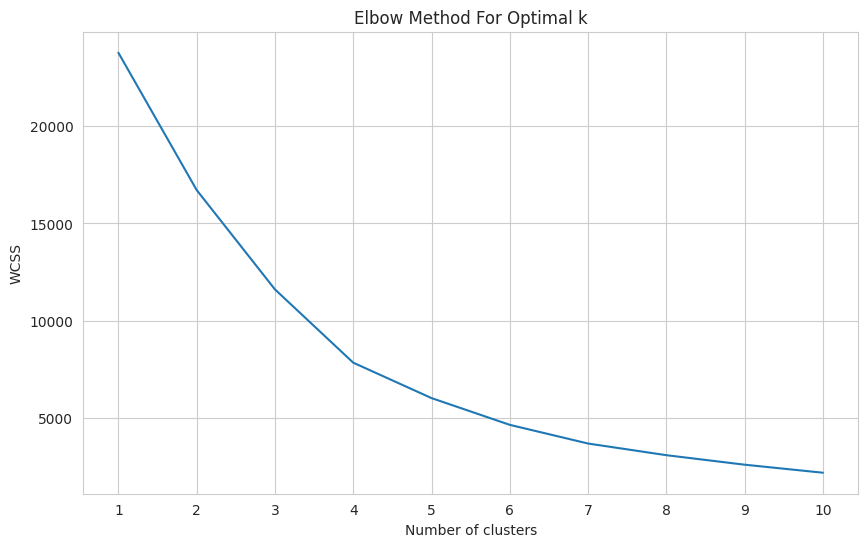

In [15]:
# Step 1: Feature Selection - Selecting Price, Rating, and No. of People rated for clustering
features = books_df[['Price', 'Rating', 'No. of People rated']]

# Step 2: Data Preprocessing - Normalizing the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Choosing the number of clusters (k) - Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe the 'elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

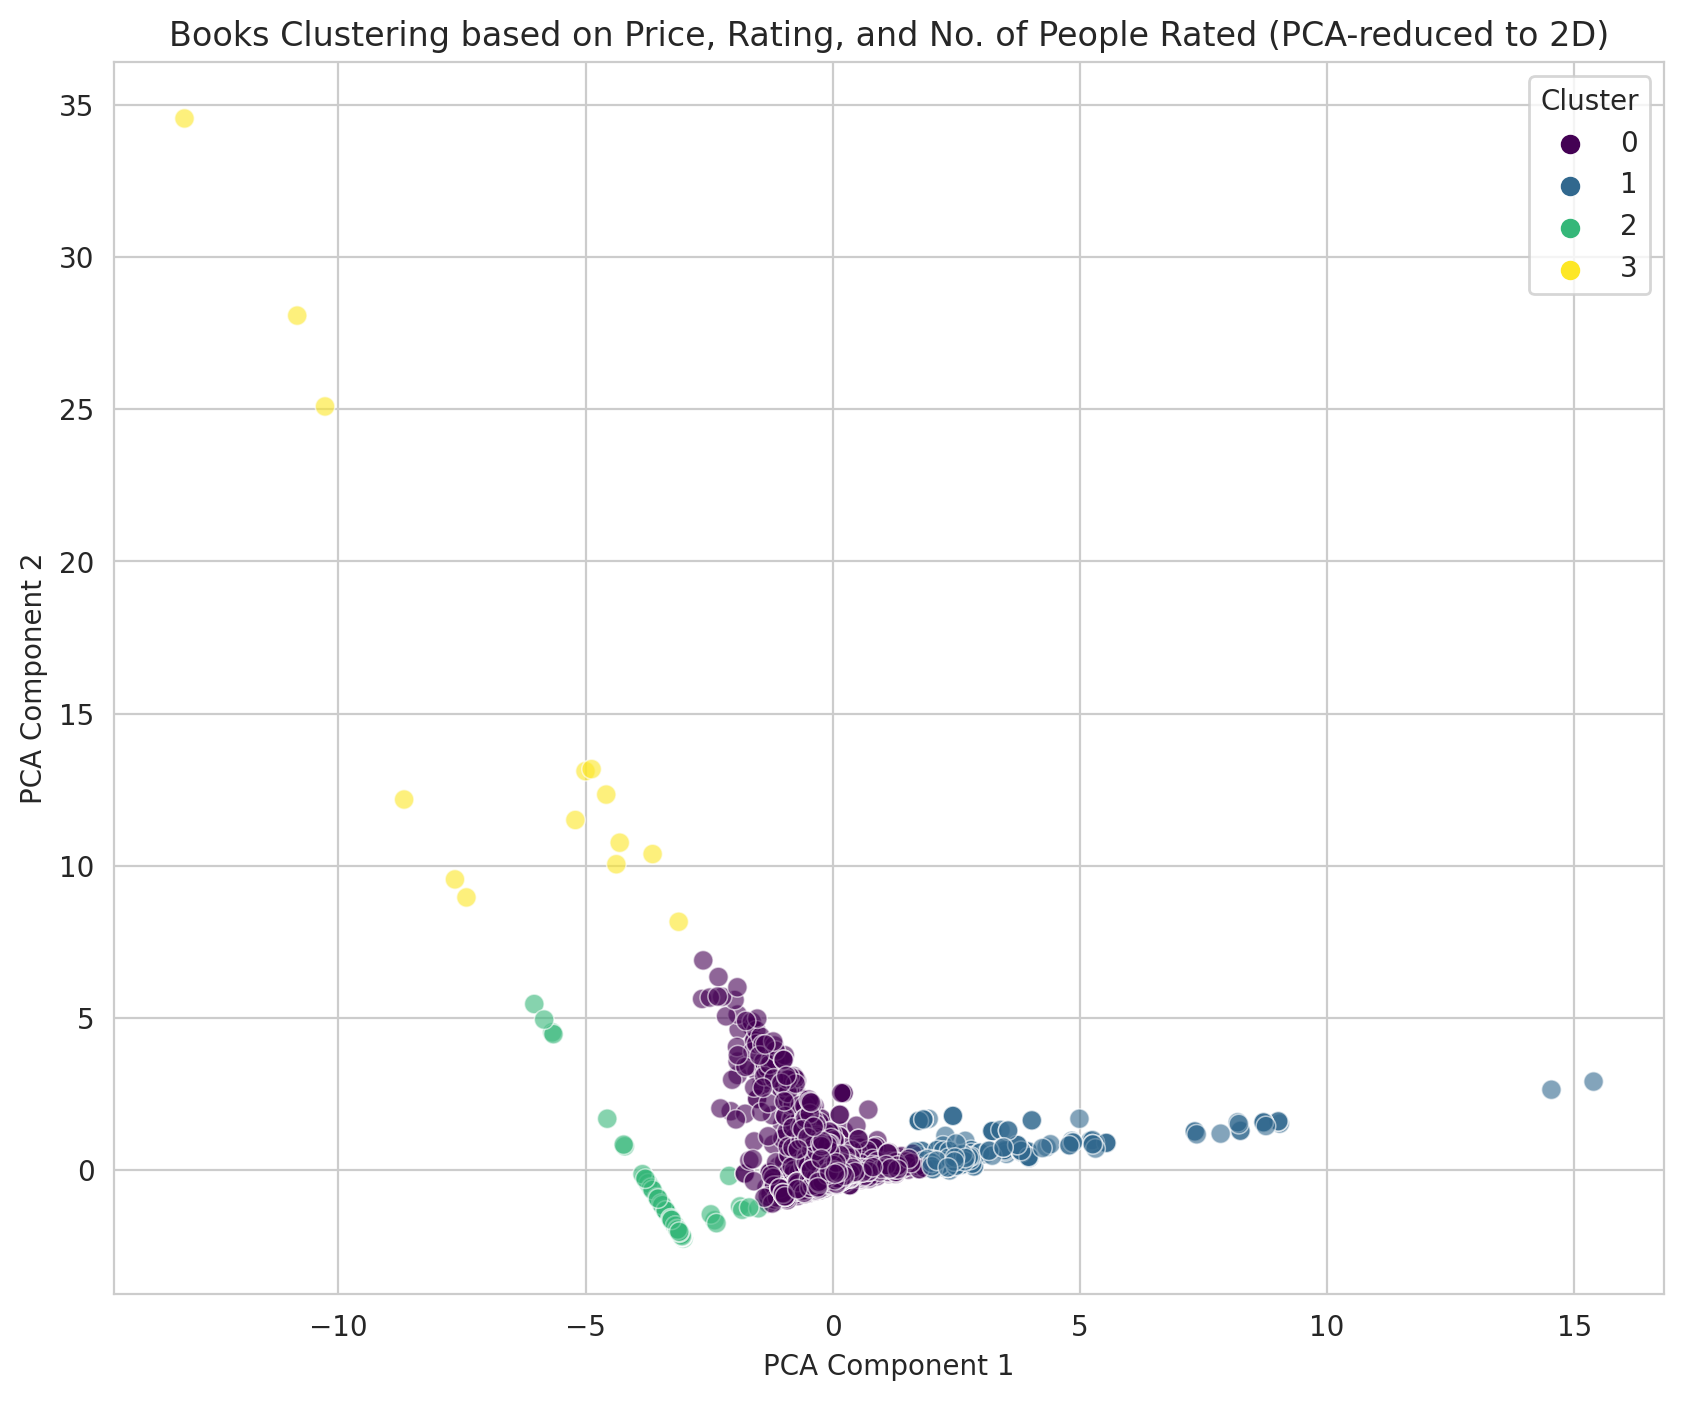

In [16]:
# Apply K-Means Clustering with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(features_scaled)

# Adding cluster labels to the original dataframe for analysis
books_df['Cluster'] = cluster_labels

# Visualization preparation - Dimensionality reduction with PCA for a 2D plot
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Scatter plot of the two PCA components colored by cluster label
plt.figure(figsize=(10, 8), dpi=200)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=cluster_labels, palette='viridis', s=50, alpha=0.6)
plt.title('Books Clustering based on Price, Rating, and No. of People Rated (PCA-reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

**Credit:**

https://www.kaggle.com/code/rewidashabaanmohamed/amazon-book-viz